## Imports

In [1]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches  
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
from scipy.stats import norm, ttest_ind
import statsmodels.api as sm
import pandas as pd 
import numpy as np
import time as t0
import subprocess
import copy
import sys 
import os 

np.set_printoptions(threshold=np.inf, precision=3, linewidth=300, suppress=False)
np.seterr(divide='ignore', invalid='ignore')
pd.set_option('display.width', 2000) 

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["pdf.fonttype"] = 42

## Meta-Analysis Functions

In [2]:
from supp_functions import ratio_Friedrich, confidence, fixed_effect, random_effect

## Included and Total Number of Articles

In [3]:

dfR    = pd.read_csv('References_T2.csv')
dfC    = pd.read_csv('Values_T2.csv')

years  = []
for ii in range(dfR.shape[0]):
    years.append(int(dfR.Reference[ii].split('_')[0]))

dfR['Year']     = years
dfR['Combined'] =  (         dfR.Tesla.astype(str)  
                     + '_' + dfR.Group.astype(str)    
                     + '_' + dfR.Add_Description.astype(str)    
                     + '_' + dfR.Localization.astype(str)    
                     + '_' + dfR.T2_Filter.astype(str)    
                     + '_' + dfR.Region.astype(str)   
                     + '_' + dfR.Tissue.astype(str))
dfR.N_Exclusions= dfR.N_Exclusions.fillna(0)

namesR = list(sorted(set(dfR.Reference)))
namesC = list(sorted(set(dfC.Reference)))

print('Total Articles   : {}'.format(len(namesR)))

namesA = copy.deepcopy(namesR)
for ii in range(len(namesR)):
    for jj in range(len(namesC)):
        if namesR[ii] == namesC[jj]:
            namesA.remove(namesR[ii])
        
print('Papers w/o values: ')
for ii in range(len(namesA)):
    print('  {:3d} {}'.format(ii+1, namesA[ii]))
    
print('')
print('Included Articles: {}'.format(len(namesR) - len(namesA)))


Total Articles   : 114
Papers w/o values: 
    1 1994_cady_2

Included Articles: 113


## Solo DataFrame

In [4]:
metabs = list(sorted(set(dfC.Name)))
metabs.remove('tCr')
metabs.remove('H2O')
metabs.remove('H2O_CSF')
metabs.remove('MM_General')

def solo_dataframe(metab, dfC, dfR, div=1):
    df_solo = pd.DataFrame({})

    dfC0    = dfC[dfC.Name == metab].reset_index(drop=True)
    arts    = list(set(dfC0.Reference))
    
    for ii in range(len(arts)):
        if len(arts) > 2:
        
            dfR1  = dfR[dfR.Reference   == arts[ii]].reset_index(drop=True)
            dfC1  = dfC0[dfC0.Reference == arts[ii]].reset_index(drop=True)

            idxs  = list(dfR1.ID)

            for jj in range(len(idxs)):
                dfR2  = dfR1[dfR1.ID == idxs[jj]].reset_index(drop=True)
                dfC2  = dfC1[dfC1.ID == idxs[jj]].reset_index(drop=True)

                if dfC2.shape[0] == 1:

                    dfR2['T2_Sub'] = dfC2.Subject[0]
                    dfR2['T2_u'  ] = dfC2.T2[0]/div
                    dfR2['T2_Std'] = dfC2.StdDev[0]/div
                    dfR2['T2_Var'] = (dfC2.StdDev[0]/div) ** 2
                    dfR2['T2_Wgt'] = 1/((dfC2.StdDev[0]/div) ** 2)
                    dfR2['T2_div'] = div
                    dfR2['T2_Met'] = metab

                    df_solo = pd.concat([df_solo, dfR2])

    return df_solo
                
df_solo = pd.DataFrame({})
for ii in range(len(metabs)):
    df_solo_ = solo_dataframe(metabs[ii], dfC, dfR)
    df_solo  = pd.concat([df_solo, df_solo_])

display(df_solo[df_solo.T2_Met == 'EtOH_CH3'])

df_solo1 = df_solo[df_solo.Group == 'Healthy' ].reset_index(drop=True)
df_solo2 = df_solo[df_solo.Group == 'Control' ].reset_index(drop=True)
df_solo3 = df_solo[df_solo.Group == 'Mid-Aged'].reset_index(drop=True)

df_solo0 = pd.concat([df_solo1,df_solo2,df_solo3])
df_solo0 = df_solo0[df_solo0.T2_Sub != 'Phantom'].reset_index(drop=True)
df_solo0 = df_solo0[df_solo0.Acq_Type == 'In Vivo'].reset_index(drop=True) 

print(df_solo0.shape)


,Completed,Download,Reference,ID,Group,Add_Description,Breed,Old_Name,Old_ID,DOI,...,Volume.1,Year,Combined,T2_Sub,T2_u,T2_Std,T2_Var,T2_Wgt,T2_div,T2_Met
0,1.0,X,2000_sammi_44,1,Healthy,Alcohol Consumption after 60 Minutes,NaN,NaN,NaN,10.1002/1522-2594(200007)44:1<35::AID-MRM7>3.0...,...,NaN,2000,4.0_Healthy_Alcohol Consumption after 60 Minut...,Human,82.0,12.0,144.0,0.006944,1,EtOH_CH3
0,1.0,X,1997_govindaraju_32,1,Control,NaN,Sprague Dawley,NaN,NaN,10.1093/oxfordjournals.alcalc.a008317,...,NaN,1997,11.7_Control_nan_Spin-Echo_0_nan_Unknown,Rat,271.0,76.0,5776.0,0.000173,1,EtOH_CH3
0,1.0,X,1997_govindaraju_32,2,Drug,NaN,Sprague Dawley,NaN,NaN,10.1093/oxfordjournals.alcalc.a008317,...,NaN,1997,11.7_Drug_nan_Spin-Echo_0_nan_Unknown,Rat,218.0,82.0,6724.0,0.000149,1,EtOH_CH3
0,1.0,X,1992_rose_23,3,Healthy,Ethanol Administration,Mongrel,NaN,NaN,10.1002/mrm.1910230213,...,NaN,1992,2.4_Healthy_Ethanol Administration_SPACE_0_nan...,Dog,335.0,20.0,400.0,0.002500,1,EtOH_CH3


(850, 70)


## Heterogeneity <a class="anchor" id="Heterogeneity"></a>
- [Return to All Metabolites](#All_Metabolites)

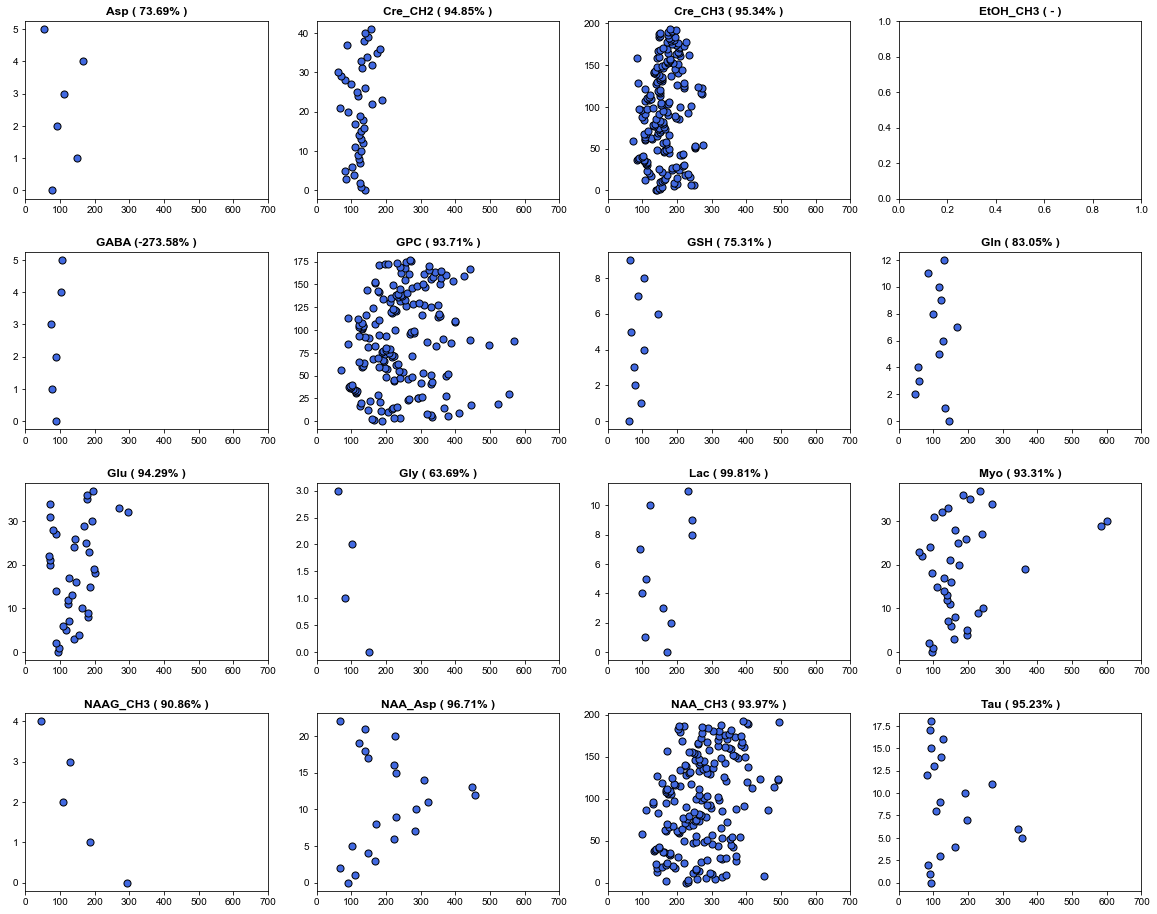

In [5]:
def plot_metab_fig(df_solo):
    metabs = list(sorted(set(df_solo.T2_Met)))
    metabs = ['Asp', 'Cre_CH2', 'Cre_CH3', 'EtOH_CH3', 'GABA', 
              'GPC', 'GSH', 'Gln', 'Glu', 'Gly', 'Lac',
              'Myo', 'NAAG_CH3', 'NAA_Asp', 'NAA_CH3', 'Tau']
    
    fig,ax = plt.subplots(4,4,figsize=(20,16))
    ax     = np.ravel(ax)

    for ii in range(len(metabs)):
        df_solo0 = df_solo[df_solo.T2_Met == metabs[ii]].reset_index(drop=True)

        div      = df_solo0.T2_div[0]

        if df_solo0.shape[0] > 3:
            ax[ii].scatter(df_solo0.T2_u.values, np.arange(df_solo0.shape[0]), color='royalblue', edgecolors='k', s=50)
            ax[ii].set_xlim([0, 700])
            effects  = random_effect(df_solo0, 'T2_u', 'T2_Wgt')
            # print('{:<8} ({:3d}): {:7.3f} ({:6.2f} {:6.2f})  |  {:6.2f}  |  {:7.3f}'.format(metabs[ii][:8], df_solo0.shape[0], effects['T']*div, effects['Low']*div, effects['Hgh']*div, effects['I2'], effects['Q'] ))
            ax[ii].set_title('{} ({:6.2f}% )'.format(metabs[ii], effects['I2']), fontsize=12, fontweight='bold')
        else:
            ax[ii].set_title('{} ( - )'.format(metabs[ii]), fontsize=12, fontweight='bold')

    plt.subplots_adjust(hspace = .3)
    plt.show()

plot_metab_fig(df_solo0)

# Weighted Meta-Regression

## Dummy Code Categorical Variables for use in Regression Analysis

In [5]:

def fit_df_solo(df_solo0):
    df_solo0 = df_solo0[['Reference', 'T2_Met', 'Tesla', 'Subject', 'Localization', 'Tissue', 'T2_Filter', 'T2_u', 'T2_Std', 'T2_Var', 'T2_Wgt', 'T2_div']]
    df_solo0 = df_solo0.fillna('0')                                             # Ignore Columns with Missing Data for String Matching

    df_solo1 = df_solo0[df_solo0.Localization == 'PRESS'].reset_index(drop=True)
    df_solo2 = df_solo0[df_solo0.Localization == 'STEAM'].reset_index(drop=True)
    df_solo3 = df_solo0[df_solo0.Localization.str.contains('LASER')].reset_index(drop=True)
    df_solo0 = pd.concat([df_solo1,df_solo2,df_solo3])
    
    df_solo0['Subj'  ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Local' ] = np.zeros([df_solo0.shape[0]])
    df_solo0['GM'    ] = np.zeros([df_solo0.shape[0]])
    df_solo0['WM'    ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Filter'] = np.zeros([df_solo0.shape[0]])

    scaler = MinMaxScaler()
    df_solo0['Tesla_'] = scaler.fit_transform(df_solo0['Tesla'].values.reshape(-1, 1))
    df_solo0['T2_u_' ] = scaler.fit_transform(df_solo0['T2_u'].values.reshape(-1, 1))

    df_solo0['Subj'  ].values[np.where(df_solo0.Subject == 'Human' )[0]] = 1

    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'PRESS')[0]] = 1
    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'STEAM')[0]] = 1

    df_solo0['GM'    ].values[np.where(df_solo0.Tissue       == 'GM'   )[0]] = 1
    df_solo0['WM'    ].values[np.where(df_solo0.Tissue       == 'WM'   )[0]] = 1
    df_solo0['Filter'].values[np.where(df_solo0.T2_Filter    != '0'    )[0]] = 1

    metabs   = list(set(df_solo0.T2_Met))
    for ii in range(len(metabs)):
        df_solo0[metabs[ii]] = np.zeros([df_solo0.shape[0]])
        df_solo0[metabs[ii]].values[np.where(df_solo0.T2_Met == metabs[ii])[0]] = 1
        
    df_solo0 = df_solo0.sort_values(by=['Tesla_', 'T2_Met', 'Subj', 'Local']).reset_index(drop=True)
    df_solo_ = pd.DataFrame({})
                                            # 'Lac', 
    morder   = ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
    for ii in range(len(morder)):
        df_solo1 = df_solo0[df_solo0.T2_Met == morder[ii]].reset_index(drop=True)
        df_solo_ = pd.concat([df_solo_, df_solo1])

    df_solo0  = df_solo_.reset_index(drop=True)
                             
    return df_solo0, scaler

## Reorganize the Data by Metabolite - Create the DataFrame that will Fit model

In [6]:
rmse     = lambda y0,y1: np.sqrt(np.mean(np.power(y0-y1, 2)))

print(list(set(df_solo0.T2_Met)))

df_fit0   = df_solo0[df_solo0.T2_Met == 'NAA_CH3' ].reset_index(drop=True)
df_fit1   = df_solo0[df_solo0.T2_Met == 'Cre_CH3' ].reset_index(drop=True)
df_fit2   = df_solo0[df_solo0.T2_Met == 'Cre_CH2' ].reset_index(drop=True)
df_fit3   = df_solo0[df_solo0.T2_Met == 'GPC'     ].reset_index(drop=True)
df_fit4   = df_solo0[df_solo0.T2_Met == 'Myo'     ].reset_index(drop=True)
df_fit5   = df_solo0[df_solo0.T2_Met == 'GABA'    ].reset_index(drop=True)
df_fit6   = df_solo0[df_solo0.T2_Met == 'Asp'     ].reset_index(drop=True)
df_fit7   = df_solo0[df_solo0.T2_Met == 'Tau'     ].reset_index(drop=True)
df_fit8   = df_solo0[df_solo0.T2_Met == 'Glu'     ].reset_index(drop=True)
df_fit9   = df_solo0[df_solo0.T2_Met == 'Gln'     ].reset_index(drop=True)
df_fit10  = df_solo0[df_solo0.T2_Met == 'GSH'     ].reset_index(drop=True)
df_fit11  = df_solo0[df_solo0.T2_Met == 'Lac'     ].reset_index(drop=True)
df_fit12  = df_solo0[df_solo0.T2_Met == 'NAAG_CH3'].reset_index(drop=True)
df_fit13  = df_solo0[df_solo0.T2_Met == 'Gly'     ].reset_index(drop=True)
df_fit14  = df_solo0[df_solo0.T2_Met == 'EtOH_CH3'].reset_index(drop=True)

df_fit    = pd.concat([df_fit0 , df_fit1 , df_fit2 , df_fit3 , df_fit4, 
                       df_fit5 , df_fit6 , df_fit7 , df_fit8 , df_fit9, 
                       df_fit10, df_fit11, df_fit12, df_fit13          ]) # df_fit11,
df_fit    = df_fit[df_fit.Tesla < 15.0]                                   # 12.0

df_fit,scaler = fit_df_solo(df_fit)
df_fit    = df_fit[df_fit.Reference != '1989_frahm_11'].reset_index(drop=True)
df_fit    = df_fit[df_fit.Subject   != 'Primate'].reset_index(drop=True)

print('\n')
print(df_fit.columns)

['MM_270', 'MM_321', 'GPC', 'Tau', 'MM_093', 'MM_375', 'Gln', 'MM_170', 'EtOH_CH3', 'NAA_CH3', 'Glu', 'GABA', 'Myo', 'Asp', 'Cre_CH2', 'Gly', 'Cre_CH3', 'Lac', 'MM_204', 'NAA_Asp', 'MM_121', 'NAAG_CH3', 'MM_226', 'GSH', 'MM_140']


Index(['Reference', 'T2_Met', 'Tesla', 'Subject', 'Localization', 'Tissue', 'T2_Filter', 'T2_u', 'T2_Std', 'T2_Var', 'T2_Wgt', 'T2_div', 'Subj', 'Local', 'GM', 'WM', 'Filter', 'Tesla_', 'T2_u_', 'Myo', 'Cre_CH3', 'Asp', 'Lac', 'GPC', 'Gln', 'Tau', 'Cre_CH2', 'NAAG_CH3', 'GSH', 'NAA_CH3', 'Glu', 'Gly', 'GABA'], dtype='object')


## Weighted Least Squares <a class="anchor" id="WLS"></a>

In [7]:

N         = df_fit.shape[0]
Coefs     = np.zeros([N, 20])                                             # [N, 19]
Error_Met = []
Error_B0  = []
Error_Loc = []
Error_Sub = []
Error_Flt = []
Error_Mod = []
Error_T2  = []
Error_Act = []
Error_Prd = []
Error_Idx = []
Error_R2  = []
Error_Ref = []
Error     = []

start     = t0.time()
cnt       = 0
print('Time  Complete   Current    Total')
for ii in range(N):
    start_    = t0.time()                                        # Time Each Iteration
    test      = np.array([ii])                                   # ii iterator will be the index for Testing

    df_fit['Test'] = np.zeros([df_fit.shape[0]])                 # Training Data = 0
    df_fit['Test'].values[test] = 1                              # Testing  Data = 1

    # Testing Data
    X_test    = df_fit[df_fit.Test == 1].reset_index(drop=True)  # Input  - Testing
    W_test    = X_test.T2_Wgt.values                             # Weight - Testing
    Y_test    = X_test.T2_u_.values                              # Output - Testing
    X_test    = X_test[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # 'Tiss', 'Filter', 'Subj'
    X_test    = sm.add_constant(X_test, has_constant='add')      # Include Regression Constant

    # Training Data
    X_train   = df_fit[df_fit.Test == 0].reset_index(drop=True)  # Input  - Training
    W_train   = X_train.T2_Wgt.values                            # Weight - Training
    Y_train   = X_train.T2_u_.values                             # Output - Training
    X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
    X_train   = sm.add_constant(X_train, has_constant='add')

    try:
        wls_model = sm.WLS(Y_train, X_train, weights=W_train)    # Weighted Multiple Regression Model
        # wls_model = sm.OLS(Y_train, X_train)                   # Ordinary Multiple Regression (no weight)
        wls_reslt = wls_model.fit()                              # Fit the Model

        Coefs[ii, :] = wls_reslt.params.values                   # Regression Coefficients

        prd_reslt = wls_reslt.predict(X_test)                    # Prediction on Testing Data

        for jj in range(len(prd_reslt)):
            Error_Mod.append(cnt)
            Error_Idx.append(test[0])
            Error_Ref.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Reference'   ][jj])
            Error_Met.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_Met'      ][jj])
            Error_B0.append( df_fit[df_fit.Test == 1].reset_index(drop=True)['Tesla'       ][jj])
            Error_Loc.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Localization'][jj])
            Error_Sub.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Subject'     ][jj])
            Error_Flt.append(X_test.Filter.values[jj])
            Error_R2.append(wls_reslt.rsquared_adj)
            Error_T2.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_u'         ][jj])
            Error_Act.append(Y_test[jj])
            Error_Prd.append(prd_reslt[jj])
            Error.append(rmse(Y_test[jj], prd_reslt[jj]))

    except Exception as e:
        print(ii, e)
        for jj in range(1):
            Error_Mod.append(cnt)
            Error_Idx.append(test[0])
            Error_Ref.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Reference'   ][jj])
            Error_Met.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_Met'      ][jj])
            Error_B0.append( df_fit[df_fit.Test == 1].reset_index(drop=True)['Tesla'       ][jj])
            Error_Loc.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Localization'][jj])
            Error_Sub.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['Subject'     ][jj])
            Error_Flt.append(X_test.Filter.values[jj])
            Error_R2.append(0.0)
            Error_T2.append(df_fit[df_fit.Test == 1].reset_index(drop=True)['T2_u'         ][jj])
            Error_Act.append(Y_test[jj])
            Error_Prd.append(0)
            Error.append(999)

    cnt +=1
    if (ii+1) % int(N//10) == 0:
        print('\t{:4.0f}%: {:7.2f}   {:8.2f}'.format(100*(ii+1)/N, t0.time()-start_, t0.time()-start))

        # if kk == (N-1) and (ii+1) % (N//100) == 0:
        #     print('\t{:4.0f}%: {:7.2f}   {:8.2f}'.format(100*(ii+1)/N, t0.time()-start_, t0.time()-start))

df_error = pd.DataFrame({'Model'       : Error_Mod,
                         'Reference'   : Error_Ref,
                         'Idx'         : Error_Idx,
                         'R^2'         : Error_R2 ,
                         'Metabolite'  : Error_Met,
                         'Tesla'       : Error_B0 ,
                         'Localization': Error_Loc,
                         'Subject'     : Error_Sub,
                         'Filter'      : Error_Flt,
                         'T2'          : Error_T2 ,
                         'Actual'      : Error_Act,
                         'Prediction'  : Error_Prd,
                         'Error'       : Error    ,
                         })

print(wls_reslt.summary())

Time  Complete   Current    Total
	  10%:    0.02       1.21
	  20%:    0.02       2.35
	  30%:    0.02       3.51
	  39%:    0.02       4.62
	  49%:    0.02       5.75
	  59%:    0.02       6.85
	  69%:    0.02       7.96
	  79%:    0.02       9.08
	  89%:    0.02      10.18
	  99%:    0.02      11.25
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            WLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     119.5
Date:                Tue, 07 Feb 2023   Prob (F-statistic):          7.79e-191
Time:                        05:41:21   Log-Likelihood:                 1026.8
No. Observations:                 628   AIC:                            -2014.
Df Residuals:                     608   BIC:                            -1925.
Df Model:                          19                           

In [8]:
lintransform  = np.linspace(0, 1, 50000)
lintransform_ = scaler.inverse_transform(lintransform.reshape(-1, 1)) 
lintransform_ = lintransform_[:,0]

linspace      = pd.DataFrame({'Input'    : lintransform,
                              'Transform': lintransform_})
# linspace.to_csv('T2_LinearTransform.csv')
linspace.head()

print(linspace.shape)

yax          = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
for ii in range(yax.shape[0]):
    lins     = copy.deepcopy(linspace.Input.values)
    lins     = np.abs(lins - yax[ii])
    
    lins_idx = np.where(lins == np.min(lins))
    print('{:3d}: {:.3f}  |  {:7.3f}'.format(ii, yax[ii], linspace.Transform.values[lins_idx][0]))

(50000, 2)
  0: 0.000  |   45.000
  1: 0.100  |  160.502
  2: 0.200  |  276.005
  3: 0.300  |  391.507
  4: 0.400  |  507.009
  5: 0.500  |  622.488
  6: 0.600  |  737.991


In [17]:
df_error_ = None
act_trans = []
prd_trans = []
err_trans = []
err_prct  = []

for ii in range(df_error.shape[0]):
    lins     = copy.deepcopy(linspace.Input.values)
    
    lins_act = np.abs(lins - df_error.Actual.values[ii])
    idx_act  = np.where(lins_act == np.min(lins_act))
    act      = linspace.Transform.values[idx_act][0]
    act_trans.append(act)
    
    lins_prd = np.abs(lins - df_error.Prediction.values[ii])
    idx_prd  = np.where(lins_prd == np.min(lins_prd))
    prd      = linspace.Transform.values[idx_prd][0]
    prd_trans.append(prd )

    err      = np.abs(act - prd)
    err_trans.append( err )

    err      = (np.abs(act - prd) / act) * 100
    err_prct.append( err )
    # print('{:2d} {:7.2f} {:7.2f}  {:7.2f}'.format(ii, act, prd, err))

df_error['Actual_Trans'] = act_trans
df_error[  'Pred_Trans'] = prd_trans
df_error[ 'Error_Trans'] = err_trans
df_error[ 'Error_Prct' ] = err_prct

print(np.quantile(df_error.Error_Prct, 0.75))
print(np.quantile(df_error.Error_Prct, 0.50))
print(np.quantile(df_error.Error_Prct, 0.25))

print(np.quantile(df_error.Error_Trans, 0.75))
print(np.quantile(df_error.Error_Trans, 0.50))
print(np.quantile(df_error.Error_Trans, 0.25))

27.289287949752865
16.232944191862096
7.513047652466111
54.65569311386224
26.611732234644705
12.058441168823393


In [17]:
display(df_error)
df_error_refs  = list(sorted(set(df_error.Reference)))
df_error_refs_ = []

for ii in range(len(df_error_refs)):
    df_error_vals = copy.deepcopy(df_error_refs[ii].split('_'))
    if len(df_error_vals)  == 3:
        df_error_refs_.append('{} {} {}'.format(df_error_vals[1], df_error_vals[0], df_error_vals[2]))
    else:
        df_error_refs_.append('{} {}'.format(df_error_vals[1], df_error_vals[0]))

    print('{:3d}:  {:>30}  |  {:<20}  '.format(ii,  df_error_refs_[ii], df_error_refs[ii][:20]))

,Model,Reference,Idx,R^2,Metabolite,Tesla,Localization,Subject,Filter,T2,Actual,Prediction,Error
0,0,2002_mascalchi_16,0,0.781594,NAA_CH3,1.5,PRESS,Human,0.0,286.0,0.208658,0.196439,0.012219
1,1,2002_mascalchi_16,1,0.781619,NAA_CH3,1.5,PRESS,Human,0.0,330.0,0.246753,0.196381,0.050373
2,2,2002_mascalchi_16,2,0.781695,NAA_CH3,1.5,PRESS,Human,0.0,323.0,0.240693,0.196434,0.044259
3,3,2002_mascalchi_16,3,0.781714,NAA_CH3,1.5,PRESS,Human,0.0,341.0,0.256277,0.196432,0.059845
4,4,2005_brief_18,4,0.781339,NAA_CH3,1.5,PRESS,Human,0.0,256.0,0.182684,0.204880,0.022196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,2020_murali-manohar_84,624,0.781818,GSH,9.4,semi-LASER,Human,0.0,74.8,0.025801,-0.013572,0.039373
625,625,2018_wyss_80,625,0.781799,GABA,3.0,PRESS,Human,0.0,75.0,0.025974,0.057626,0.031652
626,626,2018_wyss_80,626,0.781766,GABA,3.0,PRESS,Human,0.0,102.0,0.049351,0.065559,0.016208
627,627,2012_edden_35,627,0.781839,GABA,3.0,PRESS,Human,0.0,88.0,0.037229,0.064898,0.027668


  0:                 narayana 1991 9  |  1991_narayana_9       
  1:                  gideon 1992 10  |  1992_gideon_10        
  2:                   hennig 1992 5  |  1992_hennig_5         
  3:            christiansen 1993 11  |  1993_christiansen_11  
  4:                   kreis 1993 30  |  1993_kreis_30         
  5:                 blamire 1994 12  |  1994_blamire_12       
  6:                  kamada 1994 31  |  1994_kamada_31        
  7:            christiansen 1995 13  |  1995_christiansen_13  
  8:                   longo 1995 30  |  1995_longo_30         
  9:                   posse 1995 33  |  1995_posse_33         
 10:              vandertoorn 1995 8  |  1995_vandertoorn_8    
 11:                    cady 1996 21  |  1996_cady_21          
 12:                    cady 1996 36  |  1996_cady_36          
 13:                   block 1998 55  |  1998_block_55         
 14:                fujimori 1998 39  |  1998_fujimori_39      
 15:                    choi 1999 41  | 

## Leave 1 Out Model Performance

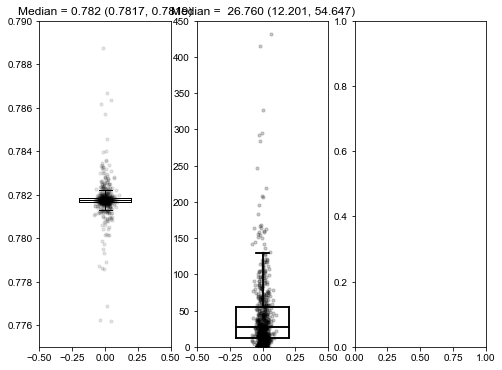

,Reference,Idx,R^2,Metabolite,Tesla,Localization,Subject,Filter,T2,T2_Pred,T2_Error,T2_Norm_Error,Actual,Prediction,Error
0,1996_cady_36,198,0.781806,GPC,2.4,PRESS,Human,0.0,498.4,213.863770,284.536230,1.393374,0.392554,0.146202,0.246352
1,2015_deelchand_73,302,0.782608,GPC,9.4,LASER,Rat,0.0,445.0,152.383512,292.616488,1.432943,0.346320,0.092973,0.253348
2,2015_deelchand_73,303,0.782452,GPC,9.4,LASER,Rat,1.0,523.0,228.154210,294.845790,1.443860,0.413853,0.158575,0.255278
3,2001_brooks_11,178,0.781841,GPC,1.5,STEAM,Human,0.0,556.0,229.787067,326.212933,1.597465,0.442424,0.159989,0.282435
4,2015_deelchand_73,555,0.782617,Myo,9.4,LASER,Rat,1.0,584.0,168.824620,415.175380,2.033114,0.466667,0.107207,0.359459
5,2015_deelchand_73,556,0.782772,Myo,9.4,LASER,Rat,1.0,600.0,168.761541,431.238459,2.111775,0.480519,0.107153,0.373367


In [24]:
df_error['T2_Pred'] = scaler.inverse_transform(df_error.Prediction.values.reshape(-1, 1)) 

rmses     = []
for ii in range(df_error.shape[0]):
    rmses.append(rmse(df_error.T2.values[ii], df_error.T2_Pred.values[ii]))
df_error['T2_Error'] = rmses
df_error['T2_Norm_Error'] = np.array(rmses)/np.mean(df_error['T2'])

R2_m   = np.median(df_error['R^2'])
R2_q1  = np.quantile(df_error['R^2'], .25)
R2_q3  = np.quantile(df_error['R^2'], .75)
R2_iqr = R2_q3-R2_q1
R2_q1_ = R2_q1 - (R2_iqr*1.75)
R2_q3_ = R2_q3 + (R2_iqr*1.75)

T2_m   = np.median(df_error['T2_Error'])
T2_q1  = np.quantile(df_error['T2_Error'], .25)
T2_q3  = np.quantile(df_error['T2_Error'], .75)
T2_iqr = T2_q3-T2_q1
T2_q1_ = T2_q1 - (T2_iqr*1.75)
T2_q3_ = T2_q3 + (T2_iqr*1.75)
T2_q1_ = 0

T2_m   = np.median(df_error['T2_Error'])
T2_q1  = np.quantile(df_error['T2_Error'], .25)
T2_q3  = np.quantile(df_error['T2_Error'], .75)
T2_iqr = T2_q3-T2_q1
T2_q1_ = T2_q1 - (T2_iqr*1.75)
T2_q3_ = T2_q3 + (T2_iqr*1.75)
T2_q1_ = 0

jitter  = np.random.normal(0,1,df_error.shape[0])
jitter *= .03

fig,ax = plt.subplots(1,3,figsize=(8,6))
ax     = np.ravel(ax)

ax[0].set_title('Median = {:5.3f} ({:6.4f}, {:6.4f})'.format(R2_m, R2_q1, R2_q3))
ax[0].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['R^2'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[0].set_ylim([0,1.0])
ax[0].plot([-0.20, 0.20], [R2_m  ,   R2_m], color='k', linewidth=1.0)
ax[0].plot([-0.20, 0.20], [R2_q1 ,  R2_q1], color='k', linewidth=1.0)
ax[0].plot([-0.20, 0.20], [R2_q3 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([ 0.20, 0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([-0.20,-0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([ 0.00, 0.00], [R2_q1_,  R2_q1], color='k', linewidth=1.0)
ax[0].plot([ 0.00, 0.00], [R2_q3_,  R2_q3], color='k', linewidth=1.0)
ax[0].plot([-0.05, 0.05], [R2_q1_, R2_q1_], color='k', linewidth=1.0)
ax[0].plot([-0.05, 0.05], [R2_q3_, R2_q3_], color='k', linewidth=1.0)
ax[0].set_xlim([-0.5, 0.5])
ax[0].set_ylim([ 0.775, 0.79])

ax[1].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(T2_m, T2_q1, T2_q3))
ax[1].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['T2_Error'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[1].set_ylim([0,1.0])
ax[1].plot([-0.20, 0.20], [T2_m  ,   T2_m], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q1 ,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q3 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.20, 0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.20,-0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q1_,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q3_,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q1_, T2_q1_], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q3_, T2_q3_], color='k', linewidth=1.5)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([ 0.0, 450])


ax[1].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(T2_m, T2_q1, T2_q3))
ax[1].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['T2_Error'].values, color='k', edgecolors='k', alpha=.1, s=10)
ax[1].set_ylim([0,1.0])
ax[1].plot([-0.20, 0.20], [T2_m  ,   T2_m], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q1 ,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q3 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.20, 0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.20,-0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q1_,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q3_,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q1_, T2_q1_], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q3_, T2_q3_], color='k', linewidth=1.5)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([ 0.0, 450])
plt.show()

df_error_ = df_error[df_error.Error > .225].reset_index(drop=True)
idxs      = list(set(df_error_.Idx))

df_comb   = pd.DataFrame({})
for ii in range(len(idxs)):
    df_comb = pd.concat([df_comb, df_error_[df_error_.Idx == idxs[ii]].head(1)])

df_comb = df_comb.reset_index(drop=True)
df_comb['T2_Pred']    = scaler.inverse_transform(df_comb.Prediction.values.reshape(-1, 1)) 

display(df_comb.sort_values(by=['Error']).reset_index(drop=True)[['Reference', 'Idx', 'R^2', 'Metabolite', 'Tesla', 'Localization', 'Subject', 'Filter', 'T2', 'T2_Pred', 'T2_Error', 'T2_Norm_Error', 'Actual', 'Prediction', 'Error']])

## Citations:

In [10]:
df_AllRefs = pd.read_csv('All_Healthy_Clinical_Citations.csv')
df_AllRefs = df_AllRefs[['Reference', 'DOI', 'Title']]
print(df_AllRefs.shape)

df_refs_   = pd.DataFrame({})

all_refs   = list(set(df_error.Reference))
for ii in range(len(all_refs)):
    df_ref0  = dfR[dfR.Reference == all_refs[ii]].head(1)
    df_ref0  = df_ref0[['Reference', 'DOI', 'Title']]
    df_refs_ = pd.concat([df_refs_, df_ref0])

print(df_refs_.shape)

df_AllRefs = pd.concat([df_AllRefs, df_refs_])
df_AllRefs_= pd.DataFrame({})

all_refs   = list(set(df_AllRefs.Reference))
for ii in range(len(all_refs)):
    df_AllRefs0 = df_AllRefs[df_AllRefs.Reference == all_refs[ii]].head(1)
    df_AllRefs_ = pd.concat([df_AllRefs_, df_AllRefs0])
    
print(df_AllRefs_.shape)
df_AllRefs_.to_csv('All_Healthy_Clinical_T2_Citations.csv')

(299, 3)
(76, 3)
(374, 3)


In [115]:
print(len(list(set(df_error.Reference))))

76


## Leave 1 Out - Adjusted R2 Histogram

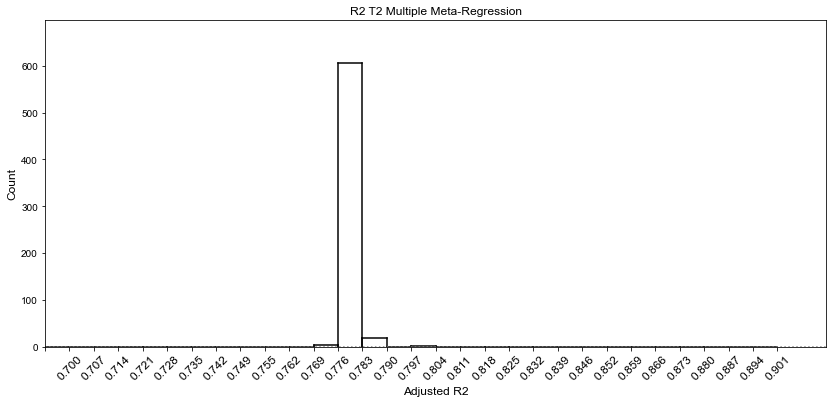

In [25]:

bin_low = .7
bin_hgh = .901
bins    = np.linspace(bin_low, bin_hgh, 30)
labels  = ['', '{:4.3f}'.format(bin_low)]

bcnts   = np.zeros([len(bins)])
for ii in range(1, len(bins)):
    for jj in range(df_error.shape[0]):
        if df_error['R^2'].values[jj] >= bins[ii-1] and df_error['R^2'].values[jj] < bins[ii]:
            bcnts[ii] +=1
    labels.append('{:4.3f}'.format(bins[ii]))
    
fig,ax  = plt.subplots(figsize=(14,6))
# ax.hist(bcnts, bins=30, color='royalblue', edgecolor='k', alpha=.75)

for ii in range(len(bins)):
    x1 = ii + 0.0
    x2 = ii + 1.0
    
    ax.plot([x1, x2], [bcnts[ii], bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x1, x1], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x2, x2], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    
    # if ii > 0:
    #     print('{:5d} {:5d} {:3d}'.format( int(bins[ii-1]), int(bins[ii]), int(bcnts[ii])))

ax.axhline(0.0, color='grey', linestyle='dotted')

ax.set_title('R2 T2 Multiple Meta-Regression', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Adjusted R2', fontsize=12)
ax.set_xticks([x for x in range(0, len(bins)+1)]) 
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_xlim([0, len(labels)+1])
ax.set_ylim([0, np.max(bcnts)*1.15])
plt.show()
# plt.savefig('Figure_T2_Model_R2_Histogram.pdf', dpi=300)

## Leave 1 Out - Error

431.23845857062014
629
 -450  -420   0
 -420  -390   0
 -390  -360   0
 -360  -330   0
 -330  -300   0
 -300  -270   0
 -270  -240   0
 -240  -210   0
 -210  -180   0
 -180  -150   0
 -150  -120   0
 -120   -90   2
  -90   -60  10
  -60   -30  64
  -30     0 177
    0    30 167
   30    60  81
   60    90  57
   90   120  37
  120   150  10
  150   180  12
  180   210   4
  210   240   1
  240   270   1
  270   300   3
  300   330   1
  330   360   0
  360   390   0
  390   420   1
  420   450   1


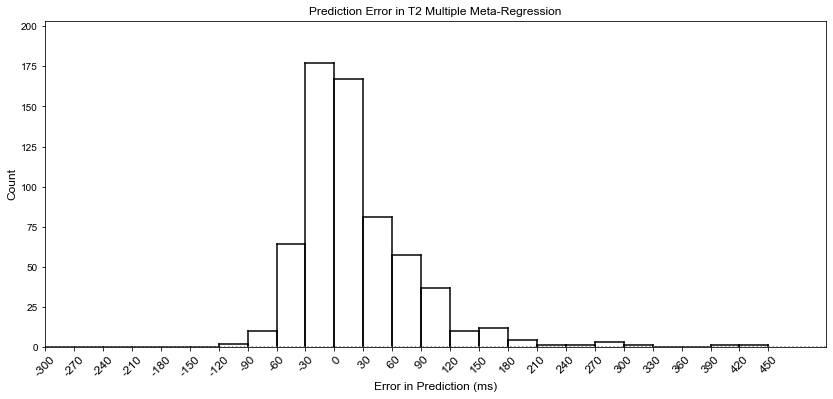

In [26]:
df_error['dist'] = (df_error.T2 - df_error.T2_Pred)
bin_low = np.min(df_error.dist)
bin_hgh = np.max(df_error.dist)
print(bin_hgh)
bin_low = -450
bin_hgh =  451
bins    = np.arange(bin_low, bin_hgh, 30)
labels  = ['', '{:3d}'.format(bin_low)]

bcnts   = np.zeros([len(bins)])
for ii in range(1, len(bins)):
    for jj in range(df_error.shape[0]):
        if df_error.dist.values[jj] >= bins[ii-1] and df_error.dist.values[jj] < bins[ii]:
            bcnts[ii] +=1
    labels.append('{:3d}'.format(int(bins[ii])))
    
print(df_error.shape[0])
fig,ax  = plt.subplots(figsize=(14,6))
# ax.hist(bcnts, bins=30, color='royalblue', edgecolor='k', alpha=.75)

for ii in range(len(bins)):
    x1 = ii + 0.0
    x2 = ii + 1.0
    
    ax.plot([x1, x2], [bcnts[ii], bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x1, x1], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    ax.plot([x2, x2], [      0.0, bcnts[ii]], color='k', linewidth=1.5)
    
    if ii > 0:
        print('{:5d} {:5d} {:3d}'.format( int(bins[ii-1]), int(bins[ii]), int(bcnts[ii])))

ax.axhline(0.0, color='grey', linestyle='dotted')

ax.set_title('Prediction Error in T2 Multiple Meta-Regression', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Error in Prediction (ms)', fontsize=12)
ax.set_xticks([x for x in range(0, len(bins)+1)]) 
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_xlim([6, len(labels)+1])
ax.set_ylim([0, np.max(bcnts)*1.15])
plt.show()
# plt.savefig('Figure_T2_Prediction_Error_Histogram.pdf', dpi=300)

## Bubble Plot on All Data

0.48051948051948046


  0: NAA_CH3
161: GPC
309: Cre_CH3
471: Lac
479: Tau
493: Glu
528: Myo
559: NAAG_CH3
564: Cre_CH2
598: Gly
602: Asp
607: Gln
618: GSH
625: GABA


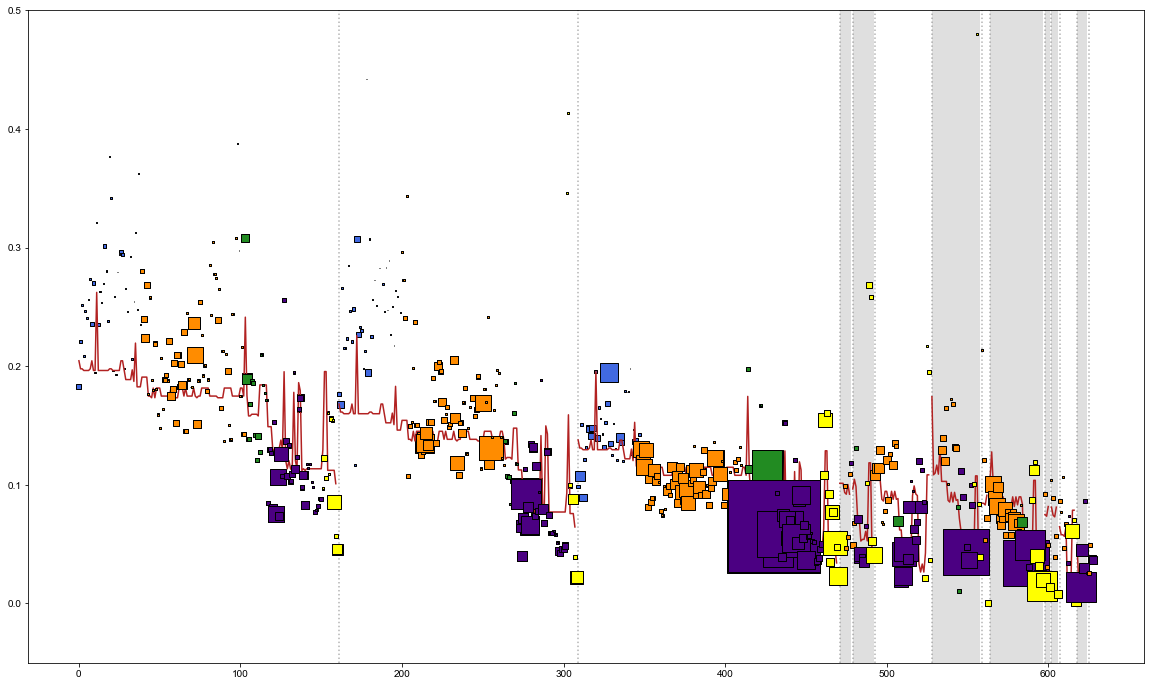

In [12]:
X_train   = copy.deepcopy(df_fit)                            # Input
W_train   = X_train.T2_Wgt.values                            # Weight
Y_train   = X_train.T2_u_.values                             # Output
X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
X_train   = sm.add_constant(X_train, has_constant='add')

wls_model = sm.WLS(Y_train, X_train, weights=W_train)        # Weighted Multiple Regression Model
wls_reslt = wls_model.fit()                                  # Fit the Model

fig, ax   = plt.subplots(figsize=(20, 12))

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

curr_met  = df_fit.T2_Met[0]
print(np.max(df_fit.T2_u_.values))

print('\n')
print('{:3d}: {}'.format(0, curr_met))

end_pnt = 471

# ax.scatter(np.arange(df_fit.T2_u_.shape[0]), df_fit.T2_u_.values, color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values, zorder=3)
ax.scatter(np.arange(end_pnt), df_fit.T2_u_.values[:end_pnt], color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[:end_pnt], zorder=3)

str_idx = 0
for ii in range(df_fit.shape[0]):
# for ii in range(472):
    if df_fit.T2_Met[ii] != curr_met:
        curr_met = df_fit.T2_Met[ii]
        ax.axvline(ii, color='k', linestyle='dotted', alpha=.3, zorder=0)
        print('{:3d}: {}'.format(ii, curr_met))
        ax.plot(np.arange(str_idx, ii-1), wls_reslt.fittedvalues[str_idx:ii-1], 'firebrick', zorder=3)
        if df_fit.Tesla[ii] == 3.0:
            ax.axvspan(str_idx, ii-1, facecolor='grey', alpha=0.25, zorder=1)
        str_idx = ii
    
    if df_fit.Tesla[ii] == 3.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='darkorange', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 3.0 and df_fit.Tesla[ii] < 5.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='forestgreen', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 3.0 and df_fit.Tesla[ii] == 7.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='indigo', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)
    elif df_fit.Tesla[ii] > 7.0:
        ax.scatter(ii, df_fit.T2_u_.values[ii], color='yellow', edgecolors='k', marker='s', s=df_fit.Area_Weight.values[ii], zorder=6)

ax.set_ylim([-.05, .5])
plt.show()


In [27]:
X_train   = copy.deepcopy(df_fit)                            # Input
W_train   = X_train.T2_Wgt.values                            # Weight
Y_train   = X_train.T2_u_.values                             # Output
X_train   = X_train[['Tesla_', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA', 'Local', 'Subj', 'Filter', 'WM', 'GM']].reset_index(drop=True) # , 'Lac', 'Local', 'Tiss', 'Filter', 'Subj'
X_train   = sm.add_constant(X_train, has_constant='add')

wls_model = sm.WLS(Y_train, X_train, weights=W_train)        # Weighted Multiple Regression Model
wls_reslt = wls_model.fit()                                  # Fit the Model


In [32]:
n100 = np.where(np.abs(linspace.values[:,1] - 100) == np.min(np.abs(linspace.values[:,1] - 100)) )[0]
n200 = np.where(np.abs(linspace.values[:,1] - 200) == np.min(np.abs(linspace.values[:,1] - 200)) )[0]
n300 = np.where(np.abs(linspace.values[:,1] - 300) == np.min(np.abs(linspace.values[:,1] - 300)) )[0]
n400 = np.where(np.abs(linspace.values[:,1] - 400) == np.min(np.abs(linspace.values[:,1] - 400)) )[0]
n500 = np.where(np.abs(linspace.values[:,1] - 500) == np.min(np.abs(linspace.values[:,1] - 500)) )[0]
n600 = np.where(np.abs(linspace.values[:,1] - 600) == np.min(np.abs(linspace.values[:,1] - 600)) )[0]

print('{:5d} {:7.4f} {:7.4f}'.format(n100[0], *linspace.values[n100,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n200[0], *linspace.values[n200,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n300[0], *linspace.values[n300,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n400[0], *linspace.values[n400,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n500[0], *linspace.values[n500,:][0]))
print('{:5d} {:7.4f} {:7.4f}'.format(n600[0], *linspace.values[n600,:][0]))

labels = np.array([0.047, 0.1342, 0.2208, 0.3074, 0.3939, 0.4805])

 2381  0.0476 100.0022
 6710  0.1342 200.0041
11039  0.2208 300.0060
15368  0.3074 400.0079
19697  0.3939 500.0098
24025  0.4805 599.9886


Max Value:   0.481
  0  39
 39 103
103 117
117 151
151 161
161 200
200 264
264 272
272 302
302 309
309 348
348 414
414 427
427 461
461 471


<ipython-input-34-e0c3b1eff316>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'white'
<ipython-input-34-e0c3b1eff316>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'darkorange'
<ipython-input-34-e0c3b1eff316>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'forestgreen'
<ipython-input-34-e0c3b1eff316>:32: SettingWithCopyWarning: 
A value is

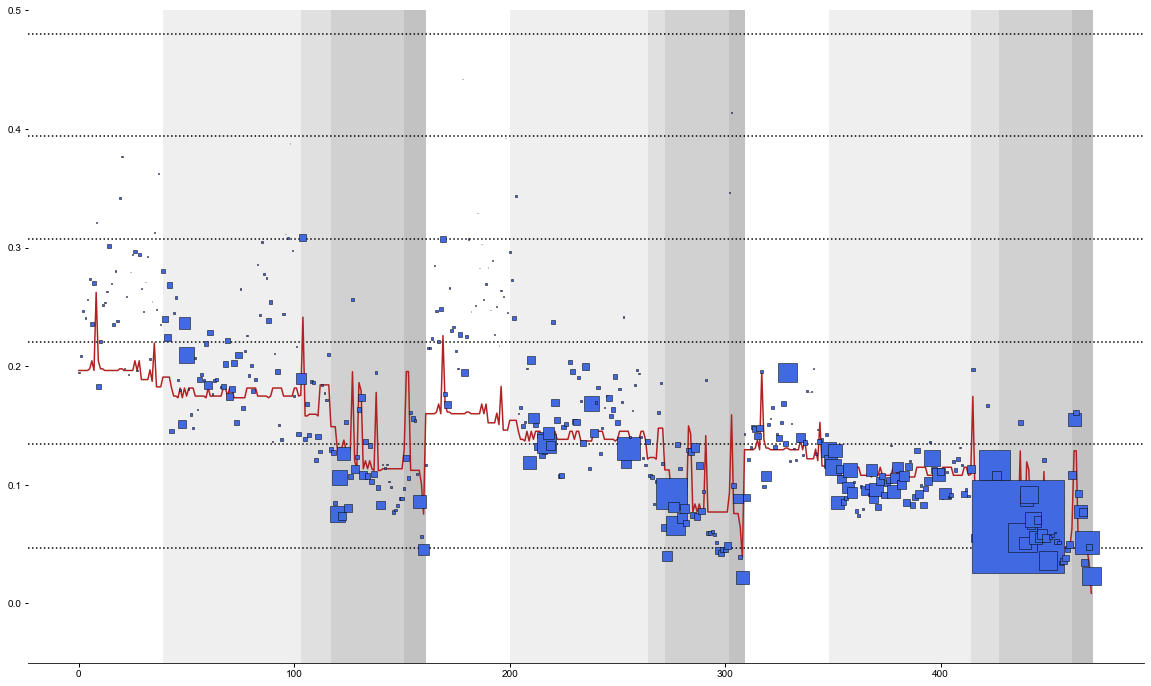

In [34]:

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

t2_met_ord= ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
included  = ['NAA_CH3', 'GPC', 'Cre_CH3',]
# included  = copy.deepcopy(t2_met_ord)

print('Max Value: {:7.3f}'.format(np.max(df_fit.T2_u_.values)))

fig, ax   = plt.subplots(figsize=(20, 12))
ax.plot(np.arange(471), wls_reslt.fittedvalues[:471], 'firebrick', zorder=3)
# ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', zorder=3)

met_idx = 0
for ii in range(len(included)):
    df_fit_t2 = df_fit[df_fit.T2_Met.str.contains(included[ii])].reset_index(drop=True)
    # display(df_fit_t2.head(3))

    end_idx   = met_idx + df_fit_t2.shape[0]
    xaxis     = np.arange(met_idx, end_idx)
    ax.scatter(xaxis, df_fit_t2.T2_u_.values, color='royalblue', edgecolors='k', linewidth=0.5, marker='s', s=df_fit_t2.Area_Weight.values, zorder=5)
    
    df_fit_t2['BackColor'] = df_fit_t2.Tesla.astype(str)
    for jj in range(df_fit_t2.shape[0]):
        if df_fit_t2.Tesla[jj] < 3.0:
            df_fit_t2['BackColor'][jj] = 'white'
        elif df_fit_t2.Tesla[jj] == 3.0:
            df_fit_t2['BackColor'][jj] = 'darkorange'
        elif df_fit_t2.Tesla[jj] > 3.0 and df_fit_t2.Tesla[jj] < 7.0:
            df_fit_t2['BackColor'][jj] = 'forestgreen'
        elif df_fit_t2.Tesla[jj] == 7.0:
            df_fit_t2['BackColor'][jj] = 'indigo'
        elif df_fit_t2.Tesla[jj] > 9.0:
            df_fit_t2['BackColor'][jj] = 'lightgray'

    colors  = ['white', 'darkorange', 'forestgreen', 'indigo', 'lightgray']
    alphas  = [0.0, .12, .24, .36, .480]
    str_idx = 0 + met_idx
    for jj in range(len(colors)):
        
        df_fit_color = df_fit_t2[df_fit_t2.BackColor.str.contains(colors[jj])].reset_index(drop=True)
        end_idx      = str_idx+df_fit_color.shape[0]
        
        print('{:3d} {:3d}'.format(str_idx, end_idx))
        ax.axvspan(str_idx, end_idx, facecolor='gray', alpha=alphas[jj], zorder=1)
        str_idx = end_idx
    met_idx = end_idx

for ii in range(labels.shape[0]):
    ax.axhline(labels[ii], color='k', linestyle='dotted')
    
ax.spines['top'   ].set_visible(False)
ax.spines['right' ].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

# ax.set_xlim([-.1, 471])
ax.set_ylim([-0.05, .5])
plt.savefig('Figure_T2_Model_Partial.pdf', dpi=300, transparent=True)
# plt.show()


In [40]:
print(wls_reslt.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            WLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     119.4
Date:                Wed, 13 Jul 2022   Prob (F-statistic):          7.20e-191
Time:                        05:46:21   Log-Likelihood:                 1028.6
No. Observations:                 629   AIC:                            -2017.
Df Residuals:                     609   BIC:                            -1928.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2508      0.006     38.589      0.0

Max Value:   0.481

  0: GABA
  0  39
 39 103
103 117
117 151
151 161
161 200
200 264
264 272
272 302
302 309
309 348
348 414
414 427
427 461
461 471


<ipython-input-24-691270019bdb>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'white'
<ipython-input-24-691270019bdb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'darkorange'
<ipython-input-24-691270019bdb>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_t2['BackColor'][jj] = 'forestgreen'
<ipython-input-24-691270019bdb>:33: SettingWithCopyWarning: 
A value is

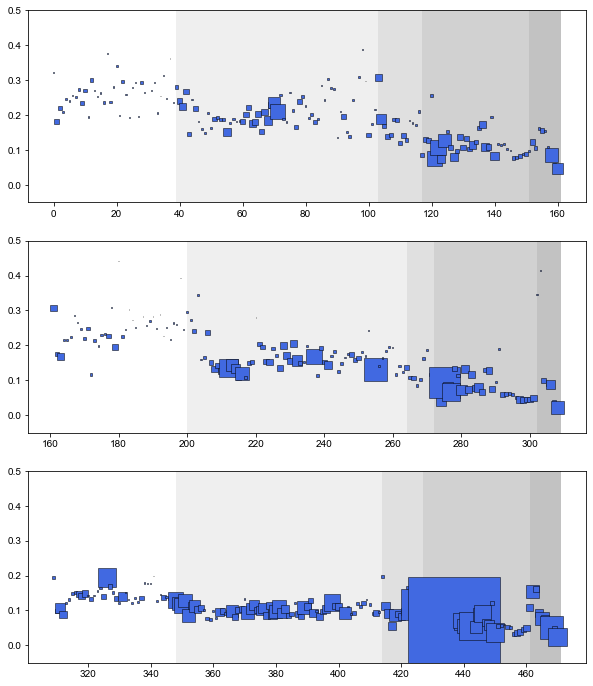

In [24]:

mult = 50000
df_fit['Area_Weight'] = (df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)) * mult

t2_met_ord= ['NAA_CH3', 'GPC', 'Cre_CH3', 'Lac', 'Tau', 'Glu', 'Myo', 'NAAG_CH3', 'Cre_CH2', 'Gly', 'Asp', 'Gln', 'GSH', 'GABA']
included  = ['NAA_CH3', 'GPC', 'Cre_CH3',]
# included  = copy.deepcopy(t2_met_ord)

print('Max Value: {:7.3f}'.format(np.max(df_fit.T2_u_.values)))
print('\n{:3d}: {}'.format(0, curr_met))

fig, ax   = plt.subplots(3,1,figsize=(10, 12))
# ax.plot(np.arange(471), wls_reslt.fittedvalues[:471], 'firebrick', zorder=3)
# ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', zorder=3)

met_idx = 0
for ii in range(len(included)):
    df_fit_t2 = df_fit[df_fit.T2_Met.str.contains(included[ii])].reset_index(drop=True)
    # display(df_fit_t2.head(3))

    end_idx   = met_idx + df_fit_t2.shape[0]
    xaxis     = np.arange(met_idx, end_idx)
    ax[ii].scatter(xaxis, df_fit_t2.T2_u_.values, color='royalblue', edgecolors='k', linewidth=0.5, marker='s', s=df_fit_t2.Area_Weight.values, zorder=5)
    
    df_fit_t2['BackColor'] = df_fit_t2.Tesla.astype(str)
    for jj in range(df_fit_t2.shape[0]):
        if df_fit_t2.Tesla[jj] < 3.0:
            df_fit_t2['BackColor'][jj] = 'white'
        elif df_fit_t2.Tesla[jj] == 3.0:
            df_fit_t2['BackColor'][jj] = 'darkorange'
        elif df_fit_t2.Tesla[jj] > 3.0 and df_fit_t2.Tesla[jj] < 7.0:
            df_fit_t2['BackColor'][jj] = 'forestgreen'
        elif df_fit_t2.Tesla[jj] == 7.0:
            df_fit_t2['BackColor'][jj] = 'indigo'
        elif df_fit_t2.Tesla[jj] > 9.0:
            df_fit_t2['BackColor'][jj] = 'lightgray'

    colors  = ['white', 'darkorange', 'forestgreen', 'indigo', 'lightgray']
    alphas  = [0.0, .12, .24, .36, .480]
    str_idx = 0 + met_idx
    for jj in range(len(colors)):
        
        df_fit_color = df_fit_t2[df_fit_t2.BackColor.str.contains(colors[jj])].reset_index(drop=True)
        end_idx      = str_idx+df_fit_color.shape[0]
        
        print('{:3d} {:3d}'.format(str_idx, end_idx))
        ax[ii].axvspan(str_idx, end_idx, facecolor='gray', alpha=alphas[jj], zorder=1)
        str_idx = end_idx
    met_idx = end_idx

    # ax[ii].set_xlim([-.1, 471])
    ax[ii].set_ylim([-.05, .5])
# plt.savefig('Figure_T2_Model.pdf', dpi=300)
plt.show()


## Bubble Plot - Leave 1 Out

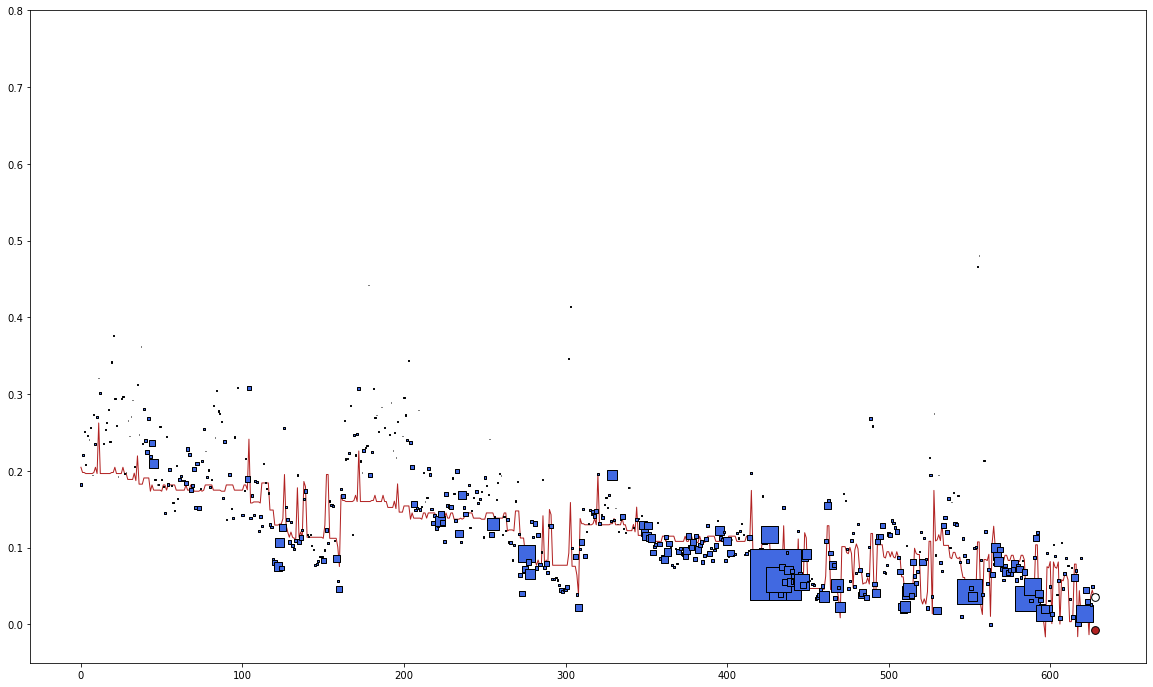

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', linewidth=1.0, zorder=0)

df_fit['Area_Weight'] = df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)
ax.scatter(np.arange(df_fit.T2_u_.shape[0]), df_fit.T2_u_.values, color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values*15000, zorder=3)
ax.scatter(test, Y_test, color='white'    , edgecolors='k', s=60, zorder=1000)
ax.scatter(test, np.array(prd_reslt)      , color='firebrick', edgecolors='k', s=60, zorder=1000)

ax.set_ylim([-.05,.8])
plt.show()

## Leave 2 Out

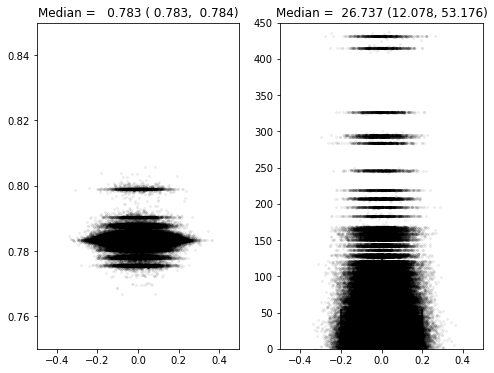

,Reference,Idx,R^2,Metabolite,Tesla,Localization,Subject,Filter,T2,T2_Pred,T2_Error,T2_Norm_Error,Actual,Prediction,Error
0,2015_deelchand_73,522_547,0.799893,Myo,9.4,LASER,Rat,1.0,584.0,174.800499,409.199501,2.000786,0.971171,0.233875,0.737296
1,2015_deelchand_73,449_547,0.785735,Myo,9.4,LASER,Rat,1.0,584.0,174.175297,409.824703,2.003842,0.971171,0.232748,0.738423
2,2015_deelchand_73,448_547,0.786061,Myo,9.4,LASER,Rat,1.0,584.0,173.057622,410.942378,2.009307,0.971171,0.230734,0.740437
3,2015_deelchand_73,547_607,0.784973,Myo,9.4,LASER,Rat,1.0,584.0,171.610691,412.389309,2.016382,0.971171,0.228127,0.743044
4,2015_deelchand_73,152_547,0.785778,Myo,9.4,LASER,Rat,1.0,584.0,171.277670,412.722330,2.018010,0.971171,0.227527,0.743644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,2015_deelchand_73,168_548,0.782909,Myo,9.4,LASER,Rat,1.0,600.0,166.500005,433.499995,2.119603,1.000000,0.218919,0.781081
1235,2015_deelchand_73,103_548,0.781314,Myo,9.4,LASER,Rat,1.0,600.0,166.071143,433.928857,2.121700,1.000000,0.218146,0.781854
1236,2015_deelchand_73,540_548,0.779615,Myo,9.4,LASER,Rat,1.0,600.0,164.972977,435.027023,2.127070,1.000000,0.216168,0.783832
1237,2015_deelchand_73,481_548,0.788852,Myo,9.4,LASER,Rat,1.0,600.0,164.585618,435.414382,2.128964,1.000000,0.215470,0.784530


In [48]:
df_error['T2_Pred'] = scaler.inverse_transform(df_error.Prediction.values.reshape(-1, 1)) 
rmses     = []
for ii in range(df_error.shape[0]):
    rmses.append(rmse(df_error.T2.values[ii], df_error.T2_Pred.values[ii]))
df_error['T2_Error'] = rmses
df_error['T2_Norm_Error'] = np.array(rmses)/np.mean(df_error['T2'])

R2_m   = np.median(df_error['R^2'])
R2_q1  = np.quantile(df_error['R^2'], .25)
R2_q3  = np.quantile(df_error['R^2'], .75)
R2_iqr = R2_q3-R2_q1
R2_q1_ = R2_q1 - (R2_iqr*1.75)
R2_q3_ = R2_q3 + (R2_iqr*1.75)

T2_m   = np.median(df_error['T2_Error'])
T2_q1  = np.quantile(df_error['T2_Error'], .25)
T2_q3  = np.quantile(df_error['T2_Error'], .75)
T2_iqr = T2_q3-T2_q1
T2_q1_ = T2_q1 - (T2_iqr*1.75)
T2_q3_ = T2_q3 + (T2_iqr*1.75)
T2_q1_ = 0

jitter  = np.random.normal(0,1,df_error.shape[0])
jitter *= .075

fig,ax = plt.subplots(1,2,figsize=(8,6))
ax     = np.ravel(ax)

ax[0].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(R2_m, R2_q1, R2_q3))
ax[0].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['R^2'].values, color='k', edgecolors='k', alpha=.05, s=4)
ax[0].set_ylim([0,1.0])
ax[0].plot([-0.20, 0.20], [R2_m  ,   R2_m], color='k', linewidth=1.5)
ax[0].plot([-0.20, 0.20], [R2_q1 ,  R2_q1], color='k', linewidth=1.5)
ax[0].plot([-0.20, 0.20], [R2_q3 ,  R2_q3], color='k', linewidth=1.5)
ax[0].plot([ 0.20, 0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.5)
ax[0].plot([-0.20,-0.20], [R2_q1 ,  R2_q3], color='k', linewidth=1.5)
ax[0].plot([ 0.00, 0.00], [R2_q1_,  R2_q1], color='k', linewidth=1.5)
ax[0].plot([ 0.00, 0.00], [R2_q3_,  R2_q3], color='k', linewidth=1.5)
ax[0].plot([-0.05, 0.05], [R2_q1_, R2_q1_], color='k', linewidth=1.5)
ax[0].plot([-0.05, 0.05], [R2_q3_, R2_q3_], color='k', linewidth=1.5)
ax[0].set_xlim([-0.5, 0.5])
ax[0].set_ylim([ 0.75, 0.85])

ax[1].set_title('Median = {:7.3f} ({:6.3f}, {:6.3f})'.format(T2_m, T2_q1, T2_q3))
ax[1].scatter(np.zeros(df_error.shape[0]) + jitter, df_error['T2_Error'].values, color='k', edgecolors='k', alpha=.05, s=4)
ax[1].set_ylim([0,1.0])
ax[1].plot([-0.20, 0.20], [T2_m  ,   T2_m], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q1 ,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([-0.20, 0.20], [T2_q3 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.20, 0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.20,-0.20], [T2_q1 ,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q1_,  T2_q1], color='k', linewidth=1.5)
ax[1].plot([ 0.00, 0.00], [T2_q3_,  T2_q3], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q1_, T2_q1_], color='k', linewidth=1.5)
ax[1].plot([-0.05, 0.05], [T2_q3_, T2_q3_], color='k', linewidth=1.5)
ax[1].set_xlim([-0.5, 0.5])
ax[1].set_ylim([ 0.0, 450])

plt.show()

df_error_ = df_error[df_error.Error > .6].reset_index(drop=True)
idxs      = list(set(df_error_.Idx))

df_comb   = pd.DataFrame({})
for ii in range(len(idxs)):
    df_comb = pd.concat([df_comb, df_error_[df_error_.Idx == idxs[ii]].head(1)])

df_comb = df_comb.reset_index(drop=True)
df_comb['T2_Pred']    = scaler.inverse_transform(df_comb.Prediction.values.reshape(-1, 1)) 

display(df_comb.sort_values(by=['Error']).reset_index(drop=True)[['Reference', 'Idx', 'R^2', 'Metabolite', 'Tesla', 'Localization', 'Subject', 'Filter', 'T2', 'T2_Pred', 'T2_Error', 'T2_Norm_Error', 'Actual', 'Prediction', 'Error']])

,Reference,T2_Met,Tesla,Subject,Localization,Tissue,T2_Filter,T2_u,T2_Std,T2_Var
0,2008_chassain_105,NAA_CH3,9.4,Mouse,PRESS,Unknown,0,171.0,55.00,3025.0000
1,1992_hennig_5,GPC,2.0,Human,PRESS,Mix,0,379.0,181.00,32761.0000
2,2001_mlynarik_14,GPC,3.0,Human,STEAM,GM,0,187.0,44.72,1999.8784
3,1992_hennig_5,Cre_CH3,2.0,Human,PRESS,Mix,0,251.0,110.00,12100.0000
4,2008_kirov_60,Cre_CH3,3.0,Human,PRESS,WM,0,173.0,14.14,199.9396
5,2008_kirov_60,Cre_CH3,3.0,Human,PRESS,WM,0,180.0,42.00,1764.0000
6,2011_marjanska_25,Tau,7.0,Human,LASER,Mix,0,93.0,7.00,49.0000
7,2011_marjanska_25,Glu,7.0,Human,LASER,WM,0,98.0,4.00,16.0000
8,2018_wyss_80,Gly,3.0,Human,PRESS,WM,0,152.0,27.00,729.0000
9,2011_marjanska_25,GSH,7.0,Human,LASER,WM,0,97.0,8.00,64.0000


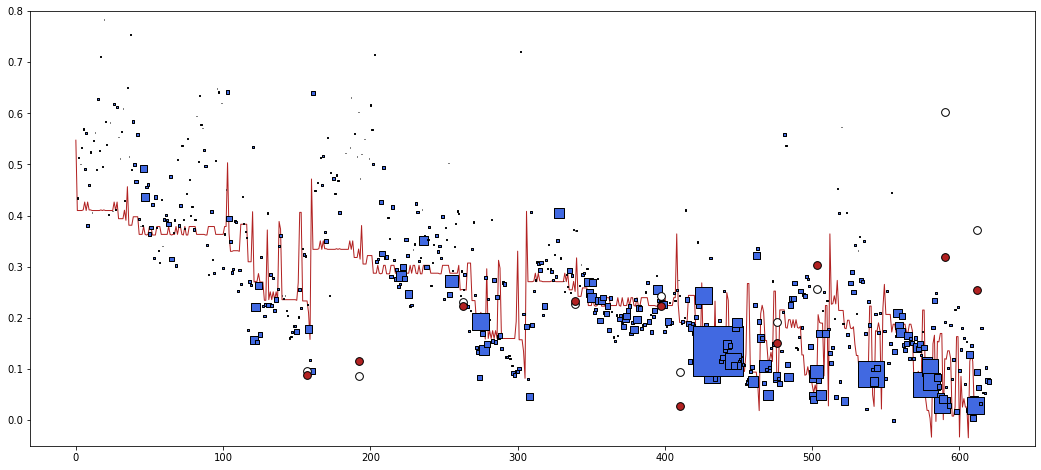

In [288]:
display(df_fit[df_fit.Test == 1].reset_index(drop=True)[['Reference', 'T2_Met', 'Tesla', 'Subject', 'Localization', 'Tissue', 'T2_Filter', 'T2_u', 'T2_Std', 'T2_Var']] )

T150    = np.where(df_fit.Tesla == 1.5)[0]
T150_n  = T150.shape[0]
T300    = np.where(df_fit.Tesla == 3.0)[0]
T300_n  = T300.shape[0] + T150.shape[0]
T700    = np.where(df_fit.Tesla == 7.0)[0]
T700_n  = T700.shape[0] + T300_n

x_line  = np.linspace(0, 1, 10)
y_line  = (  wls_reslt.params['const'  ]
           + wls_reslt.params['Cre_CH3'] * x_line 
           + wls_reslt.params['Cre_CH2'] * x_line 
           + wls_reslt.params['Myo'    ] * x_line 
           + wls_reslt.params['GABA'   ] * x_line 
           + wls_reslt.params['Asp'    ] * x_line 
           + wls_reslt.params['GPC'    ] * x_line 
           + wls_reslt.params['Tesla_' ] * x_line 
           + wls_reslt.params['Subj'   ] * x_line 
           + wls_reslt.params['Local'  ] * x_line
           + wls_reslt.params['GM'     ] * x_line
           + wls_reslt.params['WM'     ] * x_line
           + wls_reslt.params['Filter' ] * x_line) 

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(np.arange(wls_reslt.fittedvalues.shape[0]), wls_reslt.fittedvalues, 'firebrick', linewidth=1.0, zorder=0)

df_fit['Area_Weight'] = df_fit.T2_Wgt/np.sum(df_fit.T2_Wgt)
ax.scatter(np.arange(df_fit.T2_u_.shape[0]), df_fit.T2_u_.values, color='royalblue', edgecolors='k', marker='s', s=df_fit.Area_Weight.values*15000, zorder=3)
ax.scatter(test, Y_test, color='white'    , edgecolors='k', s=60, zorder=1000)
ax.scatter(test, np.array(prd_reslt)      , color='firebrick', edgecolors='k', s=60, zorder=1000)

ax.set_ylim([-.05,.8])
plt.show()

## Papers with Norm/Comp Metabolite Values

In [91]:

def available_papers(dfC, norm_metab):
    df_metab = dfC[dfC.Name.str.contains(norm_metab)].reset_index(drop=True)
    articles = list(sorted(set(df_metab.Reference)))
    return articles

articles = available_papers(dfC, 'NAA_CH3')
print('Number of Articles with NAA: {:3d}'.format(len(articles)))


Number of Articles with NAA:  96


## Separate out Norm and Comp Metabolite References

In [92]:

def norm_comp_values(articles, dfR, dfC, norm_metab, comp_metab):

    df_main   = pd.DataFrame({})
    errors    = []

    for ii in range(len(articles)):            
        dfR0  = dfR[dfR.Reference == articles[ii]].reset_index(drop=True)
        dfC0  = dfC[dfC.Reference == articles[ii]].reset_index(drop=True)
        
        comb  = list(set(dfR0.Combined))        
        for jj in range(len(comb)):
            if 'phantom' not in comb[jj].lower():
                dfR1   = dfR0[dfR0.Combined == comb[jj]].reset_index(drop=True)
                idxs   = list(set(dfR1.ID))

                df_tmp = pd.DataFrame({})
                for kk in range(len(idxs)):
                    dfR2   = dfR1[dfR1.ID == idxs[kk]].reset_index(drop=True)

                    dfC1   = dfC0[dfC0.ID == idxs[kk]].reset_index(drop=True)
                    dfC1_0 = dfC1[dfC1.Name == norm_metab].reset_index(drop=True)
                    dfC1_1 = dfC1[dfC1.Name == comp_metab].reset_index(drop=True)

                    if dfC1_0.shape[0] > 0:
                        if dfR2.N_Exclusions[0] == 0:
                            dfC1_0['N'] = dfR2.N_Total[0]
                        else:
                            dfC1_0['N'] = dfR2.N_Exclusions[0]

                    if dfC1_1.shape[0] > 0:
                        if dfR2.N_Exclusions[0] == 0:
                            dfC1_1['N'] = dfR2.N_Total[0]
                        else:
                            dfC1_1['N'] = dfR2.N_Exclusions[0]

                    df_tmp = pd.concat([df_tmp, dfC1_0, dfC1_1])
                
                try:
                    if df_tmp.shape[0] == 2:
                        df_tmp0 = df_tmp[df_tmp.Name == norm_metab].reset_index(drop=True)
                        df_tmp1 = df_tmp[df_tmp.Name == comp_metab].reset_index(drop=True)

                        dfR1['Norm_Metab'] = norm_metab
                        dfR1['Norm_u'    ] = df_tmp0.T2[0]
                        dfR1['Norm_std'  ] = df_tmp0.StdDev[0]
                        dfR1['Norm_N'    ] = df_tmp0.N[0]
                        dfR1['Comp_Metab'] = comp_metab
                        dfR1['Comp_u'    ] = df_tmp1.T2[0]
                        dfR1['Comp_std'  ] = df_tmp1.StdDev[0]
                        dfR1['Comp_N'    ] = df_tmp1.N[0]
                                                
                        Friedrich = ratio_Friedrich(dfR1.Norm_N  , dfR1.Comp_N  , 
                                                    dfR1.Norm_u  , dfR1.Comp_u  ,
                                                    dfR1.Norm_std, dfR1.Comp_std) 

                        dfR1['Friedrich_u'     ] = Friedrich['Ratio']
                        dfR1['Friedrich_Var'   ] = Friedrich['Var']
                        dfR1['Friedrich_Weight'] = 1/dfR1['Friedrich_Var']
                        dfR1['Friedrich_Low'   ] = Friedrich['Low']
                        dfR1['Friedrich_High'  ] = Friedrich['Hgh']

                        df_main = pd.concat([df_main, dfR1])

                    elif df_tmp.shape[0] > 2:
                        idxs   = list(set(df_tmp.ID))
                        for kk in range(len(idxs)):
                            df_tmp_ = df_tmp[df_tmp.ID == idxs[kk]].reset_index(drop=True)
                            df_tmp0 = df_tmp[df_tmp.Name == norm_metab].reset_index(drop=True)
                            df_tmp1 = df_tmp[df_tmp.Name == comp_metab].reset_index(drop=True)

                            dfR1['Norm_Metab'] = norm_metab
                            dfR1['Norm_u'    ] = df_tmp0.T2[0]
                            dfR1['Norm_std'  ] = df_tmp0.StdDev[0]
                            dfR1['Norm_N'    ] = df_tmp0.N[0]
                            dfR1['Comp_Metab'] = comp_metab
                            dfR1['Comp_u'    ] = df_tmp1.T2[0]
                            dfR1['Comp_std'  ] = df_tmp1.StdDev[0]
                            dfR1['Comp_N'    ] = df_tmp1.N[0]

                            Friedrich = ratio_Friedrich(dfR1.Norm_N  , dfR1.Comp_N  , 
                                                        dfR1.Norm_u  , dfR1.Comp_u  ,
                                                        dfR1.Norm_std, dfR1.Comp_std)             

                            dfR1['Friedrich_u'     ] = Friedrich['Ratio']
                            dfR1['Friedrich_Var'   ] = Friedrich['Var']
                            dfR1['Friedrich_Weight'] = 1/dfR1['Friedrich_Var']
                            dfR1['Friedrich_Low'   ] = Friedrich['Low']
                            dfR1['Friedrich_High'  ] = Friedrich['Hgh']

                            df_main = pd.concat([df_main, dfR1])
                except Exception as e:
                    errors.append([articles[ii], e])
                    
    return df_main, errors


## Confirm Main Dataframe

In [93]:
df_main,_ = norm_comp_values(articles, dfR, dfC, 'NAA_CH3', 'Cre_CH3')
articles_ = list(set(df_main.Reference))

print('Number of Articles: {:3d}'.format(len(articles_)))
print('Number of Groups  : {:3d}'.format(df_main.shape[0]))

Number of Articles:  88
Number of Groups  : 322


## Populations Included within Study

In [94]:
def populations(df):
    pops = list(set(df.Group))
    print('Number of Unique Populations: {:3d}'.format(len(pops)))
    print('       Population  Articles  Groups')
    for ii in range(len(pops)):
        df_  = df[df.Group == pops[ii]].reset_index(drop=True)
        arts = list(set(df_.Reference))
        print('    {:2d}. {:<10}   {:3d}     {:3d}'.format(ii, pops[ii][:10], len(arts), df_.shape[0]))

populations(df_main)


Number of Unique Populations:  23
       Population  Articles  Groups
     0. Edema          2       3
     1. Reperfusio     1       1
     2. Ischemia       6      22
     3. Cancer         1      11
     4. Schizophre     2       4
     5. Multiple S     1       2
     6. BDM/SZ         1       2
     7. Bipolar        1       3
     8. Alzheimer'     2       2
     9. Healthy       56     152
    10. Drug           1       2
    11. Tumor          2       6
    12. Mid-Aged       1      10
    13. Control       29      59
    14. Newborn        1       3
    15. MCI            1       1
    16. Aged           6      20
    17. Parkinsons     1       1
    18. WMSH           1       1
    19. Adolescent     1      10
    20. Stroke         4       4
    21. PKU            1       1
    22. ALS            2       2


## Breakdown with Only Considering Healthy Populations:

In [95]:
df_main0 = df_main[df_main.Group == 'Healthy' ]
df_main1 = df_main[df_main.Group == 'Control' ]
df_main2 = df_main[df_main.Group == 'Mid-Aged']
df_main_ = pd.concat([df_main0, df_main1, df_main2])

print('Total Papers    : {:3d}'.format(len(list(set(df_main.Reference)))))
print('Remaining Papers: {:3d}'.format(len(list(set(df_main_.Reference)))))
print('Remaining Groups: {:3d}'.format(df_main_.shape[0]))


Total Papers    :  88
Remaining Papers:  85
Remaining Groups: 221


## Breakdown by Metabolite:

In [96]:
metabs = list(sorted(set(dfC.Name)))
metabs.remove('tCr')
metabs.remove('H2O')
metabs.remove('H2O_CSF')
metabs.remove('MM_General')

df_final = pd.DataFrame({})
print('  Metabolite   Groups')
for ii in range(len(metabs)):
    # df_final_,_ = norm_comp_values(articles, dfR, dfC, 'NAA_CH3', metabs[ii])
    df_final_,_ = norm_comp_values(articles, dfR, dfC, metabs[ii], 'NAA_CH3')
    df_final0   = df_final_[df_final_.Group == 'Healthy' ]
    df_final1   = df_final_[df_final_.Group == 'Control' ]
    df_final2   = df_final_[df_final_.Group == 'Mid-Aged']    
    df_final    = pd.concat([df_final, df_final0, df_final1, df_final2])
    df_final    = df_final[~df_final.Subject.str.contains('Phantom')].reset_index(drop=True)
    
    df_final['Acq_Type'] = df_final.Acq_Type.fillna('0')    
    df_final    = df_final[ df_final.Acq_Type.str.contains('In Vivo')].reset_index(drop=True)

    total       = df_final0.shape[0] + df_final1.shape[0] + df_final2.shape[0]
    if total < 2:
        print('{:2d}   {:<7}:   {:4d} ***'.format(ii, metabs[ii][:7], total))
    else:
        print('{:2d}   {:<7}:   {:4d}'.format(ii, metabs[ii][:7], total))
        
print('Total : ', df_final.shape[0])

  Metabolite   Groups
 0   Asc    :      4
 1   Asp    :      6
 2   Cre_CH2:     49
 3   Cre_CH3:    221
 4   EtOH_CH:      3
 5   GABA   :      4
 6   GPC    :    207
 7   GPC_Gly:      3
 8   GPC_Mul:      3
 9   GSH    :     14
10   Glc    :      2
11   Gln    :     18
12   Glu    :     40
13   Glx    :      3
14   Gly    :      5
15   Lac    :     19
16   MM_093 :      6
17   MM_121 :      9
18   MM_140 :     14
19   MM_170 :      7
20   MM_204 :      2
21   MM_226 :      4
22   MM_256 :      2
23   MM_270 :      2
24   MM_299 :      2
25   MM_321 :      2
26   MM_362 :      2
27   MM_375 :      4
28   MM_386 :      2
29   MM_403 :      2
30   Myo    :     46
31   NAAG_As:      3
32   NAAG_CH:      6
33   NAAG_Gl:      3
34   NAA_Asp:     31
35   NAA_CH1:      1 ***
36   NAA_CH3:    230
37   PCho   :      3
38   PCr_CH3:      1 ***
39   PE     :      4
40   Phe    :      0 ***
41   Scy    :      7
42   Tau    :     20
Total :  983


In [97]:
human    = df_final[df_final.Subject == 'Human'].reset_index(drop=True)
human_150= human[human.Tesla == 1.5].reset_index(drop=True)[['Reference', 'Group', 'Norm_Metab', 'Comp_Metab']]
human_300= human[human.Tesla == 3.0].reset_index(drop=True)[['Reference', 'Group', 'Norm_Metab', 'Comp_Metab']]
human_700= human[human.Tesla == 7.0].reset_index(drop=True)[['Reference', 'Group', 'Norm_Metab', 'Comp_Metab']]

print('Total Papers 1.5: {:3d}'.format(len(list(set(human_150.Reference)))))
print('Total Papers 3.0: {:3d}'.format(len(list(set(human_300.Reference)))))
print('Total Papers 7.0: {:3d}'.format(len(list(set(human_700.Reference)))))

remove = ['GPC', 'tCho', 'Cre_CH3', 'Cre_CH2', 'NAA_CH3', 'tNAA', 'Gly']

tpubs  = []

print('1.5 Tesla')
a = list(set(human_150.Reference))
for ii in range(len(a)):
    dfa = human_150[human_150.Reference == a[ii]].reset_index(drop=True)
    a_  = list(set(dfa.Norm_Metab))
    
    for jj in range(len(remove)):
        if remove[jj] in a_:
            a_.remove(remove[jj])
    if len(a_) >= 1:
        tpubs.append(a[ii])
        print(a[ii], a_[:6])
    
print('3.0 Tesla')
a = list(set(human_300.Reference))
for ii in range(len(a)):
    dfa = human_300[human_300.Reference == a[ii]].reset_index(drop=True)
    a_  = list(set(dfa.Norm_Metab))
    
    for jj in range(len(remove)):
        if remove[jj] in a_:
            a_.remove(remove[jj])
    if len(a_) >= 1:
        tpubs.append(a[ii])
        print(a[ii], a_[:6])
        
print('7.0 Tesla')
a = list(set(human_700.Reference))
for ii in range(len(a)):
    dfa = human_700[human_700.Reference == a[ii]].reset_index(drop=True)
    a_  = list(set(dfa.Norm_Metab))
    
    for jj in range(len(remove)):
        if remove[jj] in a_:
            a_.remove(remove[jj])
    if len(a_) >= 1:
        tpubs.append(a[ii])
        print(a[ii], a_[:6])
        
print(tpubs)
print(len(tpubs))
print(len(list(set(tpubs))))

Total Papers 1.5:  22
Total Papers 3.0:  22
Total Papers 7.0:  11
1.5 Tesla
1995_posse_33 ['Myo']
2005_kreis_54 ['Myo']
1989_frahm_11 ['Lac', 'Tau', 'Myo']
2005_soher_53 ['MM_170', 'MM_093', 'MM_375', 'NAA_Asp', 'Myo', 'MM_226']
1993_kreis_30 ['Myo']
3.0 Tesla
2015_zhang_76 ['Gln', 'Glu']
2012_ganji_25 ['NAAG_CH3', 'NAA_Asp', 'Myo', 'Glu']
2018_deelchand_79 ['NAA_Asp', 'Myo', 'Glu']
2018_wyss_80 ['Asc', 'GPC_Gly', 'Scy', 'Tau', 'GPC_Mult', 'NAAG_Asp']
2020_deelchand_95 ['Myo', 'Glu']
2021_dacko_85 ['Lac']
7.0 Tesla
2017_an_78 ['Gln', 'NAA_Asp', 'Glu']
2011_marjanska_25 ['Scy', 'NAA_Asp', 'Tau', 'Myo', 'GSH', 'Glu']
2018_li_79 ['Glu']
2017_chen ['Lac']
2018_wong_31 ['NAA_Asp', 'Myo', 'GSH', 'Glu']
2018_swanberg_290 ['Myo', 'GSH', 'Glu']
['1995_posse_33', '2005_kreis_54', '1989_frahm_11', '2005_soher_53', '1993_kreis_30', '2015_zhang_76', '2012_ganji_25', '2018_deelchand_79', '2018_wyss_80', '2020_deelchand_95', '2021_dacko_85', '2017_an_78', '2011_marjanska_25', '2018_li_79', '2017_chen

## Number of Papers from Field Strength
 - 1.5 = 5
 - 3.0 = 6
 - 7.0 = 6

## Move Included Articles to Separate Directory for Easier Citation Management

In [98]:
pubs    = list(set(df_final.Reference))
print(len(pubs))

basedir = 'C:/Users/agudm/Desktop/NMR_T2'
destdir = 'C:/Users/agudm/Desktop/Relaxation_Citations'

import os
cnt = 0
for ii in range(len(pubs)):

    if os.path.exists('{}/{}.pdf'.format(destdir, pubs[ii])) == False:
        print('{:3d} '.format(cnt), pubs[ii])
        cnt+=1
    script = 'cp {}/{}.pdf {}/{}.pdf'.format(basedir, pubs[ii], destdir, pubs[ii])

    # P        = subprocess.Popen('{}'.format(script), shell=True)
    # P.wait() 
    

86


## Total Number of References Included in Analysis

In [99]:
total_arts = list(set(df_final.Reference))
print('Total Number: {:3d}'.format(len(total_arts)))

Total Number:  86


## All Groups Independed from Each Paper

In [81]:
def Independent_Groups(df, norm_metab, comp_metab, sort_by='Year', plot=True, verbose=True):

    df  = df.sort_values(by=[sort_by], ascending=False).reset_index(drop=True)
    Fix = combined_fixed_effect( df, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
    Ran = combined_random_effect(df, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
    
    if verbose == True:
        print('\nIndependent Groups by Paper:  ')
        print('         Fixed Effect   Random Effect')
        print('ES   :     {:7.4f}        {:7.4f}  '.format(Fix[ 0], Ran[ 0]))
        print('CI-Lw:     {:7.4f}        {:7.4f}  '.format(Fix[-2], Ran[-2]))
        print('CI-Hg:     {:7.4f}        {:7.4f}  '.format(Fix[-1], Ran[-1]))
        print('Var  :     {:7.4f}        {:7.4f}  '.format(Fix[ 1], Ran[ 1]))
        print('SE/SD:     {:7.4f}        {:7.4f}  '.format(Fix[ 2], Ran[ 2]))
        print('Z    :     {:7.4f}        {:7.4f}  '.format(Fix[ 3], Ran[ 3]))
        print('Wgts :     {:7.4f}        {:7.4f}  '.format(Fix[ 6], Ran[ 6]))
        print('p1way:     {:7.4f}        {:7.4f}  '.format(Fix[ 4], Ran[ 4]))
        print('p2way:     {:7.4f}        {:7.4f}  '.format(Fix[ 5], Ran[ 5]))

    fig,ax = plt.subplots(figsize=(12,40))
    area   = .1

    ax.scatter(Fix[0], 0, color='white', edgecolors='k', marker=(4, 0, 90), s=200)#* (1/Fixed_Effect[1]))
    ax.plot([Fix[-2], Fix[-1]], [0, 0], linewidth=1.25, color='k')

    for ii in range(df.shape[0]):

        if df.Group[ii] == 'Healthy':
            mcolor = 'white'
        elif df.Group[ii] == 'Control':
            mcolor = 'white'
        else:
            mcolor = 'darkorange'
        msize  = area * df.Friedrich_Weight[ii]

        ax.scatter(df.Friedrich_u[ii], ii+1, color='white', edgecolors='k', marker='s', s=msize) #(4, 0, 90)
        ax.plot([df.Friedrich_Low[ii], df.Friedrich_High[ii]], [ii+1, ii+1], linewidth=1.00, color='k')

    ylabels = [' ', 'Fixed Combined Effect']
    ylabels.extend(list(df.Reference))
    ax.set_yticks([y for y in range(-2, len(ylabels)-2)]) 
    ax.set_yticklabels(ylabels, rotation=0, fontsize=12)

    ax.set_xlim([-2.5, 5.0])    
    ax.axvline(0.0, linestyle='dotted', color='k', alpha=.6)
    plt.show()

    return Fix, df.shape[0]

df_final_       = df_final[df_final.Comp_Metab == 'Cre_CH3'].reset_index(drop=True)
Fixed_Effect, N = Independent_Groups(df_final_, 'NAA_CH3', 'Cre_CH3', plot=True)

NameError: name 'combined_fixed_effect' is not defined

In [100]:
def tidxs(teslas):
    
    t150   = np.where(teslas == 1.50)[0]
    t300   = np.where(teslas == 3.00)[0]
    t400   = np.where(np.logical_and(teslas >= 3.50, teslas <= 5.00))[0]
    t700   = np.where(teslas == 7.00)[0]
    t940   = np.where(teslas == 9.40)[0]
    
    cidx   = [t150, t300, t400, t700, t940]
    
    return cidx


256.971 246.284 267.658  |  47/221 =   0.21  |   93.521
 
345.347 327.427 363.267  |    0/ 37 =   0.00 |   41.948
277.416 267.402 287.430  |    0/ 73 =   0.00 |   69.688
264.122 232.449 295.794  |   14/ 26 =   0.54 |   90.101
178.409 168.782 188.036  |   10/ 47 =   0.21 |   77.481
207.718 201.798 213.639  |   14/ 17 =   0.82 |


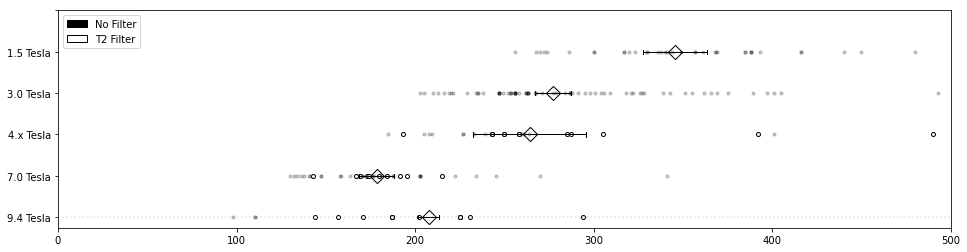

In [101]:

fig,ax   = plt.subplots(figsize=(16,4))
ax.axvline(0.0, color='grey', linestyle='dotted', alpha=.6)

df_met   = []
df_ran_u = []
df_ran_l = []
df_ran_h = []
df_fix_u = []
df_fix_l = []
df_fix_h = []

eff      = 'ran'
tkwargs  = {'horizontalalignment': 'left'  ,
            'verticalalignment'  : 'center'}

df_final0 = df_final[df_final.Norm_Metab == 'NAA_CH3'].reset_index(drop=True)
# df_final1 = df_final0[df_final0.Subject != 'Human'].reset_index(drop=True)
# df_final0 = df_final0[df_final0.Subject == 'Human'].reset_index(drop=True)

ax.axhline(0, color='grey', linestyle='dotted', alpha=.25)
# ax.text(-70.0, 4, '1.5 Tesla', **tkwargs)

tidx  = tidxs(df_final0.Tesla.values)
tidx.reverse()
const = 500

df_new        = pd.DataFrame({})
df_new['u']   = df_final0.Norm_u.values  / const
df_new['Std'] = df_final0.Norm_std.values/ const
df_new['Var'] = df_new.Std.values ** 2
df_new['Wgt'] = 1/df_new.Var.values
df_new['Sub'] = df_final0.Subject.values
T2_filter     = np.where(df_new.Sub != 'Human')[0]

n  = df_new.shape[0]
n_ = T2_filter.shape[0]
p  = T2_filter.shape[0]/(df_new.shape[0]+.0001)

comb_eff  = random_effect(df_new, Tcol='u', Wcol='Wgt')
print('{:7.3f} {:7.3f} {:7.3f}  |  {:2d}/{:2d} = {:6.2f}  |  {:7.3f}'.format(comb_eff['T']*const, comb_eff['Low']*const, comb_eff['Hgh']*const, n_, n, p, comb_eff['I2']))
print(' ')

for ii in range(len(tidx)-1,-1,-1):
    df_new        = pd.DataFrame({})
    df_new['u']   = df_final0.Norm_u.values[tidx[ii]]   / const
    df_new['Std'] = df_final0.Norm_std.values[tidx[ii]] / const
    df_new['T2F'] = df_final0.T2_Filter.values[tidx[ii]]
    df_new['T2F'] = df_new.T2F.fillna('0')
    df_new['Subject'] = df_final0.Subject.values[tidx[ii]]
    
    T2_filter     = np.where(df_new.Subject != 'Human')[0]
    # T2_filter     = np.where(df_new.T2F != '0')[0]
        
    df_new['Var'] = df_new.Std.values ** 2
    df_new['Wgt'] = 1/df_new.Var.values
    
    vals          = df_new.u.values * const
    
    if eff == 'fix' or ii == 0:
        comb_eff  = fixed_effect( df_new, Tcol='u', Wcol='Wgt')
    elif eff == 'ran':
        comb_eff  = random_effect(df_new, Tcol='u', Wcol='Wgt')

    comb_u    = comb_eff['T' ] * const
    comb_l    = comb_eff['Low'] * const
    comb_h    = comb_eff['Hgh'] * const

    n  = df_new.shape[0]
    n_ = T2_filter.shape[0]
    p  = T2_filter.shape[0]/(df_new.shape[0]+.0001)
    
    if 'I2' in list(comb_eff.keys()):
        print('{:7.3f} {:7.3f} {:7.3f}  |  {:3d}/{:3d} = {:6.2f} |  {:7.3f}'.format(comb_u, comb_l, comb_h, n_, n, p, comb_eff['I2']))
    else:
        print('{:7.3f} {:7.3f} {:7.3f}  |  {:3d}/{:3d} = {:6.2f} |'.format(comb_u, comb_l, comb_h, n_, n, p))
        
    # ax.axhline(ii, color='grey', linestyle='dotted', alpha=.10)
    ax.scatter(comb_u, ii, color='white', edgecolors='k', linewidth=1.0, marker=(4, 0, 90), s=200)
    ax.plot([comb_l, comb_h], [ii-.00, ii+.00], linewidth=1.00, color='k')
    ax.plot([comb_l, comb_l], [ii-.05, ii+.05], linewidth=1.00, color='k')
    ax.plot([comb_h, comb_h], [ii-.05, ii+.05], linewidth=1.00, color='k')
    ax.scatter(vals, np.ones(vals.shape[0]) * ii, color='k', edgecolors='k', s=10, alpha=.2)        
    ax.scatter(vals[T2_filter], np.ones(T2_filter.shape[0]) * ii, color='white', edgecolors='k', s=16)        

# df_mets = pd.DataFrame({'Metabolite'   : df_met[1]  ,
#                         'Random_Effect': df_ran_u[1],
#                         'Random_Low'   : df_ran_l[1],
#                         'Random_Hgh'   : df_ran_h[1],                        
#                         'Fixed_Effect' : df_fix_u[1],
#                         'Fixed_Low'    : df_fix_l[1],
#                         'Fixed_Hgh'    : df_fix_h[1]})
# df_mets.to_csv('T2_NAA_CH3_Values.csv')

black = mpatches.Patch(facecolor='black', edgecolor='k', label='No Filter') 
white = mpatches.Patch(facecolor='white', edgecolor='k', label='T2 Filter') 
ax.legend(handles=[black, white], loc=2) 

ax.set_yticks([y for y in range(len(tidx)+1)]) 
ax.set_yticklabels(['9.4 Tesla', '7.0 Tesla', '4.x Tesla', '3.0 Tesla', '1.5 Tesla', ' '])
ax.set_xlim([0, 400])
# plt.savefig('Figure_T2_NAA_Without_Scatter_Without_Lines.pdf', dpi=300)

ax.set_xlim([0, 500])
plt.show()

In [245]:
def fit_df_solo(df_solo0):
    df_solo0 = df_solo0.fillna('0')

    df_solo1 = df_solo0[df_solo0.Localization == 'PRESS'].reset_index(drop=True)
    df_solo2 = df_solo0[df_solo0.Localization == 'STEAM'].reset_index(drop=True)
    df_solo3 = df_solo0[df_solo0.Localization.str.contains('LASER')].reset_index(drop=True)
    df_solo0 = pd.concat([df_solo1,df_solo2,df_solo3])
    
    df_solo0['Subj'  ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Local' ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Tiss'  ] = np.zeros([df_solo0.shape[0]])
    df_solo0['Filter'] = np.zeros([df_solo0.shape[0]])

    scaler = MinMaxScaler()
    df_solo0['Tesla_'] = scaler.fit_transform(df_solo0['Tesla'].values.reshape(-1, 1))
    df_solo0['u'     ] = scaler.fit_transform(df_solo0['Friedrich_u'].values.reshape(-1, 1))

    df_solo0['Subj'  ].values[np.where(df_solo0.Subject == 'Human' )[0]] = 1

    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'PRESS')[0]] = 1
    df_solo0['Local' ].values[np.where(df_solo0.Localization == 'STEAM')[0]] = 1

    df_solo0['Tiss'  ].values[np.where(df_solo0.Tissue       == 'WM'   )[0]] = 1
    df_solo0['Filter'].values[np.where(df_solo0.T2_Filter    != '0'    )[0]] = 1
    
    return df_solo0

df_final_ = df_final[df_final.Norm_Metab == 'Cre_CH3'].reset_index(drop=True)
df_final0 = df_final_[['Reference', 'Tesla', 'T2_Filter', 'Subject', 'Localization', 'Tissue', 'Friedrich_u', 'Friedrich_Var', 'Friedrich_Weight']]
df_final0 = fit_df_solo(df_final0)

df_final0 = df_final0.sort_values(by=['Tesla', 'Local', 'Filter'])
df_final0 = df_final0.reset_index(drop=True)

test      = np.random.randint(0, df_final0.shape[0], 4)
df_final0['Test'] = np.zeros([df_final0.shape[0]])
df_final0.Test.values[test] = 1

X_train   = df_final0[df_final0.Test == 0].reset_index(drop=True)
Y_train   = X_train['u']
W_train   = X_train['Friedrich_Weight']
X_train   = X_train[['Tesla_', 'Filter', 'Subj', 'Tiss']] # 'Local',
X_train   = sm.add_constant(X_train)

X_test    = df_final0[df_final0.Test == 1].reset_index(drop=True)
Y_test    = X_test['u']
W_test    = X_test['Friedrich_Weight']
X_test    = X_test[['Tesla_', 'Filter', 'Subj', 'Tiss']] # 'Local',
X_test    = sm.add_constant(X_test)

wls_model = sm.WLS(Y_train, X_train, weights=W_train)
wls_reslt = wls_model.fit()

prd_reslt = wls_reslt.predict(X_test)
for ii in range(len(prd_reslt)):
    print('{:3d}: {:6.4f}  {:6.4f}  {:6.4f}  |  {:.3f}'.format(ii, Y_test[ii], prd_reslt[ii], rmse(Y_test[ii], prd_reslt[ii]), X_test.Tesla_[ii]))
    
print(wls_reslt.summary())
print(wls_reslt.params)

  0: 0.1546  0.2254  0.0708  |  0.077
  1: 0.1775  0.2254  0.0479  |  0.077
  2: 0.2735  0.2360  0.0375  |  0.128
  3: 0.2765  0.3781  0.1016  |  0.281
                            WLS Regression Results                            
Dep. Variable:                      u   R-squared:                       0.501
Model:                            WLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     47.44
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.43e-27
Time:                        14:43:40   Log-Likelihood:                 84.617
No. Observations:                 194   AIC:                            -159.2
Df Residuals:                     189   BIC:                            -142.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

                            WLS Regression Results                            
Dep. Variable:                      u   R-squared:                       0.499
Model:                            WLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     46.87
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.75e-27
Time:                        14:26:01   Log-Likelihood:                 84.267
No. Observations:                 193   AIC:                            -158.5
Df Residuals:                     188   BIC:                            -142.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3182      0.034      9.483      0.0

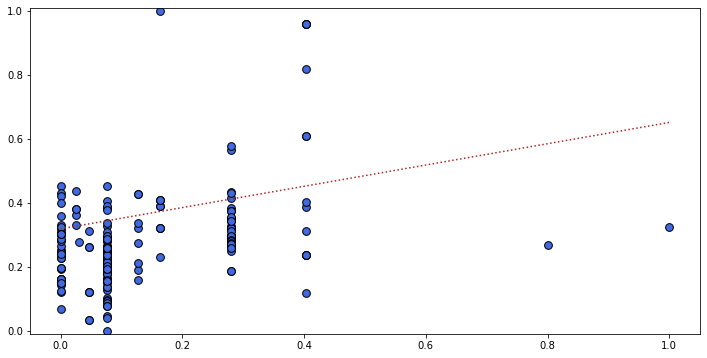

In [154]:

x_line  = np.linspace(0, 1, 10)
y_line  = (  wls_reslt.params['const' ]
           + wls_reslt.params['Tesla_'] * x_line 
           + wls_reslt.params['Subj'  ] * x_line 
           + wls_reslt.params['Tiss'  ] * x_line
           + wls_reslt.params['Filter'] * x_line) 

print(wls_reslt.summary())

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df_final0.Tesla_.values, df_final0.u.values, color='royalblue', edgecolors='k', s=60)
ax.plot(x_line, y_line, 'firebrick', linestyle='dotted')

# ax.scatter(test, df_solo0_.T2_u_.values[test], color='white'    , edgecolors='k', s=60)
# ax.scatter(test, np.array(prd_reslt)         , color='firebrick', edgecolors='k', s=60)

ax.set_ylim([-.01,1.01])
plt.show()

## All Metabolites <a class="anchor" id="All_Metabolites"></a>
- [Return to WLS](#WLS)

Tau       99.30
 1 PE         4  -7.65  |
 2 PCr_CH3    1
PCho      96.20
NAA_Asp   99.44
NAAG_Glu  47.48
NAAG_CH3  89.69
NAAG_Asp  62.61
Myo       99.00
Lac       99.37
Gly       23.45
Glx       12.14
Glu       97.06
Gln       64.83
Glc       46.88
GSH       71.43
GPC_Mult  96.08
GPC_Gly   96.83
GPC       96.99
19 GABA       4  -3.77  |
EtOH_CH3  82.00
Cre_CH3   88.22
Cre_CH2   94.01
23 Asp        6 -72.29  |
Asc       83.65


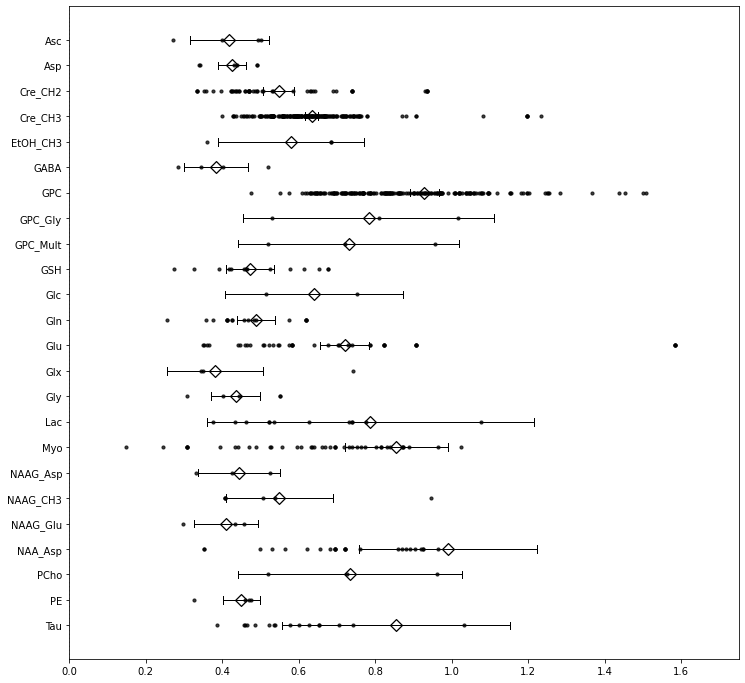

In [103]:

all_metabs  = copy.deepcopy(metabs)
all_metabs_ = []
for ii in range(len(all_metabs)):
    if 'MM_' in all_metabs[ii]:
        all_metabs_.append(all_metabs[ii])
for ii in range(len(all_metabs_)):
    all_metabs.remove(all_metabs_[ii])
    all_metabs.append(all_metabs_[ii])

all_metabs.remove('Scy')
all_metabs.remove('NAA_CH3')
all_metabs.remove('Phe')
all_metabs.remove('NAA_CH1')

all_metabs = all_metabs[:25]
all_metabs.reverse()

fig,ax   = plt.subplots(figsize=(12,12))
ax.axvline(0.0, color='grey', linestyle='dotted', alpha=.6)

df_met   = [[],[]]
df_ran_u = [[],[]]
df_ran_l = [[],[]]
df_ran_h = [[],[]]
df_fix_u = [[],[]]
df_fix_l = [[],[]]
df_fix_h = [[],[]]

cnt      = 0
tkwargs  = {'horizontalalignment': 'left'  ,
            'verticalalignment'  : 'center'}

inc      = []
for ii in range(len(all_metabs)):
    eff       = 'ran'
    df_final_ = df_final[df_final.Norm_Metab == all_metabs[ii]].reset_index(drop=True)
        
    if df_final_.shape[0] >= 2:

        inc.append(all_metabs[ii])
        # ax.axhline(cnt, color='grey', linestyle='dotted', alpha=.15)

        vals     = df_final_.Friedrich_u.values
        ones     = np.ones([vals.shape[0]]) * cnt

        fix      = fixed_effect(df_final_ , Tcol='Friedrich_u', Wcol='Friedrich_Weight')
        ran      = random_effect(df_final_, Tcol='Friedrich_u', Wcol='Friedrich_Weight')
        
        if ran['I2'] > 0:
            print('{:<8} {:6.2f}'.format(all_metabs[ii][:8], ran['I2']))
            # print('{:2d} {:<8} {:3d} {:6.2f}  |  {:7.4f}'.format(ii, all_metabs[ii][:8], df_final_.shape[0], ran['I2'], ran['Q']))
        else:
            print('{:2d} {:<8} {:3d} {:6.2f}  |'.format(ii, all_metabs[ii][:8], df_final_.shape[0], ran['I2']))
        
        ast = ''
        if all_metabs[ii] in ['Asp']:
            eff = 'fix'
            
        if eff == 'fix':
            ax.scatter(fix['T'], cnt, color='white', edgecolors='k', linewidth=1.25, marker=(4, 0, 90), s=140)
            ax.plot([fix['Low'], fix['Hgh']], [cnt, cnt], linewidth=1.00, color='k')
            ax.plot([fix['Hgh'], fix['Hgh']], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            ax.plot([fix['Low'], fix['Low']], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            # ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.10)
            ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.75)
            ast = '*'
        elif eff == 'ran':
            ax.scatter(ran['T'], cnt, color='white', edgecolors='k', linewidth=1.25, marker=(4, 0, 90), s=140)
            ax.plot([ran['Low'], ran['Hgh']], [cnt, cnt], linewidth=1.00, color='k')
            ax.plot([ran['Hgh'], ran['Hgh']], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            ax.plot([ran['Low'], ran['Low']], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            # ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.10)    
            ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.75)    

        cnt +=1
        
    else:
        print('{:2d} {:<8} {:3d}'.format(ii, all_metabs[ii][:8], df_final_.shape[0]))

        
# df_mets = pd.DataFrame({'Metabolite'   : df_met[1]  ,
#                         'Random_Effect': df_ran_u[1],
#                         'Random_Low'   : df_ran_l[1],
#                         'Random_Hgh'   : df_ran_h[1],                        
#                         'Fixed_Effect' : df_fix_u[1],
#                         'Fixed_Low'    : df_fix_l[1],
#                         'Fixed_Hgh'    : df_fix_h[1]})

# df_mets.to_csv('T2_Metabolite_Values.csv')

ax.set_yticks([y for y in range(cnt)]) 
ax.set_yticklabels(inc)
ax.set_xlim([0.0, 1.75])
plt.show()
# plt.savefig('Figure_T2_Mets_With_Scatter_Without_Lines.pdf', dpi=300)

 0 MM_403     2
 1 MM_386     2
 2 MM_375     4
 3 MM_362     2
 4 MM_321     2
 5 MM_299     2
 6 MM_270     2
 7 MM_256     2
 8 MM_226     4
 9 MM_204     2
10 MM_170     7
11 MM_140     7
12 MM_121     2
13 MM_093     6


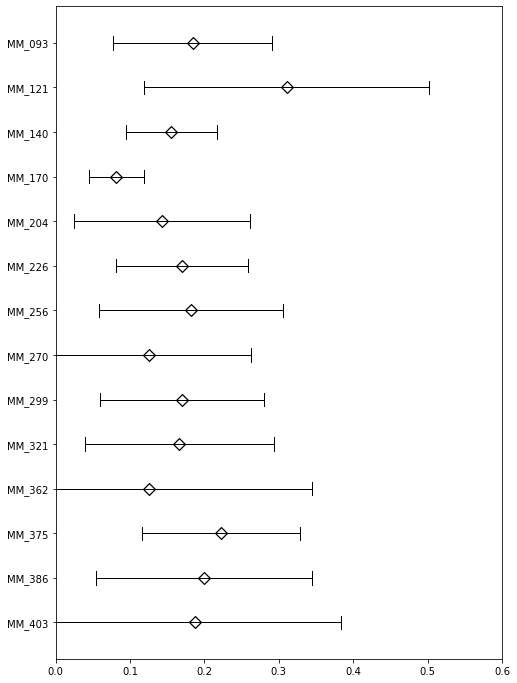

In [55]:

all_metabs  = copy.deepcopy(metabs)
all_metabs_ = []
for ii in range(len(all_metabs)):
    if 'MM_' in all_metabs[ii]:
        all_metabs_.append(all_metabs[ii])
for ii in range(len(all_metabs_)):
    all_metabs.remove(all_metabs_[ii])
    all_metabs.append(all_metabs_[ii])

all_metabs.remove('Scy')
all_metabs.remove('NAA_CH3')
all_metabs.remove('Phe')
all_metabs.remove('NAA_CH1')

all_metabs = all_metabs[25:]
all_metabs.reverse()

fig,ax   = plt.subplots(figsize=(8,12))
ax.axvline(0.0, color='grey', linestyle='dotted', alpha=.6)

df_met   = [[],[]]
df_ran_u = [[],[]]
df_ran_l = [[],[]]
df_ran_h = [[],[]]
df_fix_u = [[],[]]
df_fix_l = [[],[]]
df_fix_h = [[],[]]

cnt      = 0
tkwargs  = {'horizontalalignment': 'left'  ,
            'verticalalignment'  : 'center'}

inc      = []
for ii in range(len(all_metabs)):
    eff       = 'fix'
    df_final_ = df_final[df_final.Norm_Metab == all_metabs[ii]].reset_index(drop=True)
    
    print('{:2d} {:<8} {:3d}'.format(ii, all_metabs[ii][:8], df_final_.shape[0]))
    
    if df_final_.shape[0] >= 2:

        inc.append(all_metabs[ii])
        # ax.axhline(cnt, color='grey', linestyle='dotted', alpha=.15)

        vals      = df_final_.Friedrich_u.values
        ones     = np.ones([vals.shape[0]]) * cnt

        fix      = combined_fixed_effect(df_final_ , Tcol='Friedrich_u', Wcol='Friedrich_Weight')
        ran      = combined_random_effect(df_final_, Tcol='Friedrich_u', Wcol='Friedrich_Weight')

        ast = ''
        if all_metabs[ii].lower() in ['mm_093', 'mm_140']:
            eff = 'ran'
        if eff == 'fix':
            ax.scatter(fix[0], cnt, color='white', edgecolors='k', linewidth=1.25, marker=(4, 0, 90), s=140)
            ax.plot([fix[-2], fix[-1]], [cnt, cnt], linewidth=1.00, color='k')
            ax.plot([fix[-1], fix[-1]], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            ax.plot([fix[-2], fix[-2]], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            # ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.10)
            ast = '*'
        elif eff == 'ran':
            ax.scatter(ran[0], cnt, color='white', edgecolors='k', linewidth=1.25, marker=(4, 0, 90), s=140)
            ax.plot([ran[-2], ran[-1]], [cnt, cnt], linewidth=1.00, color='k')
            ax.plot([ran[-1], ran[-1]], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            ax.plot([ran[-2], ran[-2]], [cnt-.15, cnt+.15], linewidth=1.00, color='k')
            # ax.scatter(vals, ones, color='k', edgecolors='k', s=10, alpha=.10)    

        cnt +=1

# df_mms = pd.DataFrame({'Metabolite'   : df_met[1]  ,
#                         'Random_Effect': df_ran_u[1],
#                         'Random_Low'   : df_ran_l[1],
#                         'Random_Hgh'   : df_ran_h[1],                        
#                         'Fixed_Effect' : df_fix_u[1],
#                         'Fixed_Low'    : df_fix_l[1],
#                         'Fixed_Hgh'    : df_fix_h[1]})

# df_mms.to_csv('T2_Metabolite_Values.csv')

ax.set_yticks([y for y in range(cnt)]) 
ax.set_yticklabels(inc)
ax.set_xlim([0.0, .60])
plt.savefig('Figure_T2_MMs_Without_Scatter_With_Lines.pdf', dpi=300)

## Run Full Analysis

NAA_CH3  MM_403     5.440(± 1.812)   6.394(± 2.529)    1    1
NAA_CH3  MM_386     5.078(± 1.717)   5.005(± 2.237)    1    1
NAA_CH3  MM_375     4.464(± 1.297)   7.688(± 2.773)    2    2
NAA_CH3  MM_362     8.213(± 2.567)   9.261(± 3.043)    1    1
NAA_CH3  MM_321     6.062(± 1.977)   6.099(± 2.470)    1    1
NAA_CH3  MM_299     5.904(± 1.934)   5.891(± 2.427)    1    1
NAA_CH3  MM_270     8.069(± 2.526)   8.212(± 2.866)    1    1
NAA_CH3  MM_256     5.541(± 1.838)   5.633(± 2.373)    1    1
NAA_CH3  MM_226     5.915(± 1.609)  10.072(± 3.174)    2    2
NAA_CH3  MM_204     7.053(± 2.245)   7.234(± 2.690)    1    1
NAA_CH3  MM_170     7.414(± 1.759)  12.071(± 3.474)    5    3
NAA_CH3  MM_140     4.138(± 0.998)   9.404(± 3.067)    7    4
NAA_CH3  MM_121     3.369(± 0.974)   8.863(± 2.977)    4    3
NAA_CH3  MM_093     3.705(± 1.078)   8.585(± 2.930)    4    3
NAA_CH3  Tau        1.828(± 0.329)   2.029(± 1.424)   17   11
NAA_CH3  Scy        1.875(± 0.432)   2.037(± 1.427)    7    2
NAA_CH3 

C:\Users\agudm\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


NAA_CH3  GPC        1.132(± 0.095)   1.362(± 1.167)  240   82
NAA_CH3  GABA       2.814(± 0.608)   2.897(± 1.702)    4    3
NAA_CH3  EtOH_CH3   2.251(± 1.138)   2.960(± 1.720)    2    2


C:\Users\agudm\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


NAA_CH3  Cre_CH3    1.619(± 0.100)   1.834(± 1.354)  255   88
NAA_CH3  Cre_CH2    1.953(± 0.227)   2.227(± 1.492)   42   19
NAA_CH3  Asp        1.824(± 0.306)   2.186(± 1.478)   19   11
NAA_CH3  Asc        2.404(± 0.532)   2.318(± 1.523)    4    2


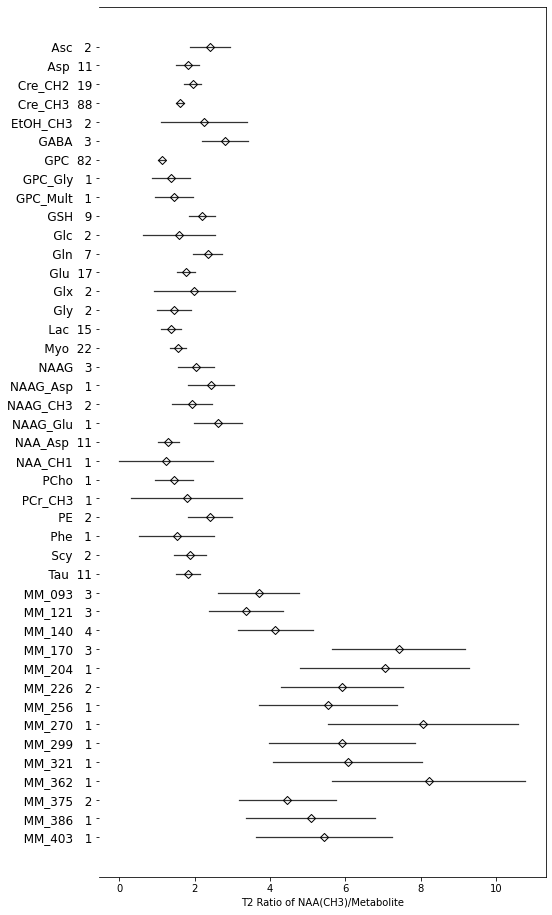

In [124]:
norm_metab  = 'NAA_CH3'

plot        = False
verbose     = False
area        = 65

all_metabs  = list(sorted(set(dfC.Name)))
all_metabs.remove('MM_General')
all_metabs.remove('NAA_CH3')
all_metabs.remove('H2O')
all_metabs.remove('H2O_CSF')

all_metabs_ = []
for ii in range(len(all_metabs)):
    if 'MM_' in all_metabs[ii]:
        all_metabs_.append(all_metabs[ii])
for ii in range(len(all_metabs_)):
    all_metabs.remove(all_metabs_[ii])
    all_metabs.append(all_metabs_[ii])
    
all_metabs = all_metabs[::-1]
fig, ax     = plt.subplots(figsize=(8,16))
for ii in range(len(all_metabs)):

    names_metab         = available_papers(dfC, norm_metab)
    fields              = breakdown_field(names_metab, dfR, verbose=False)
    df_relative         = norm_comp_values(names_metab, dfR, dfC, norm_metab, all_metabs[ii])
    combination         = comp_df(df_relative, norm_metab, all_metabs[ii])
    df_final            = combination[0]
    Monte_Carlo         = combination[1]

    Indepent_Effects    = Independent_Groups(df_final, Monte_Carlo, norm_metab, all_metabs[ii], plot=plot, verbose=verbose)
    Ind_Fixed_Effect    = Indepent_Effects[0]
    Ind_Random_Effect   = Indepent_Effects[1]
    Ind_Monte_Carlo     = Indepent_Effects[2]
    Ind_N               = Indepent_Effects[3]

    df_combined         = Study_Combined(df_final, clinical=False, verbose=verbose)
    Study_Effects       = Overall_Effects(df_combined, Monte_Carlo, norm_metab, all_metabs[ii], sort_by='Year', plot=plot, verbose=verbose)
    Study_Fixed_Effect  = Study_Effects[0]
    Study_Random_Effect = Study_Effects[1]
    Study_Monte_Carlo   = Study_Effects[2]
    Study_N             = Study_Effects[3]

    ax.plot([Study_Fixed_Effect[-2], Study_Fixed_Effect[-1]], [ii, ii], linewidth=1.25, color='k', alpha=.8)
    ax.scatter(Study_Fixed_Effect[0], ii, color='white', edgecolors='k', marker=(4, 0, 90), s=area)#* (1/Study_Fixed_Effect[1]))

    print('{:<8} {:<8} {:7.3f}({}{:6.3f}) {:7.3f}({}{:6.3f})  {:3d}  {:3d}'.format(norm_metab, all_metabs[ii], Study_Fixed_Effect[0], u'\u00B1', Study_Fixed_Effect[2] * 1.96, Monte_Carlo[0], u'\u00B1', Monte_Carlo[2], int(Ind_N), int(Study_N)))
    
    all_metabs[ii]      = '{:>8} {:3d}'.format(all_metabs[ii][:8], int(Study_N))
    # ax.bar(ii, Study_Fixed_Effect[0], width=.40, color='white' , edgecolor='k', linewidth=1.25, hatch=None)
    # # ax.bar(ii-.15, Study_Fixed_Effect[0], width=.30, color='royalblue' , edgecolor='k', linewidth=1.25, hatch=None)
    # # ax.bar(ii+.15, Study_Monte_Carlo[ 0], width=.30, color='darkorange', edgecolor='k', linewidth=1.25, hatch=None)
    # ax.plot([ii, ii], [Study_Fixed_Effect[0], Study_Fixed_Effect[-1]], color='k', linewidth=1.25, )
    # ax.plot([ii, ii], [Study_Fixed_Effect[0], Study_Fixed_Effect[-2]], color='k', linewidth=1.25, )

ylabels = []
ylabels.extend(all_metabs)
ax.set_yticks([y for y in range(0, len(ylabels))]) 
ax.set_yticklabels(ylabels, fontsize=12)
ax.spines['left'].set_visible(False)
ax.set_xlabel('T2 Ratio of NAA(CH3)/Metabolite')

# xlabels = []
# xlabels.extend(all_metabs)
# ax.set_xticks([x for x in range(0, len(xlabels))]) 
# ax.set_xticklabels(xlabels, rotation=45, fontsize=12)

# white = mpatches.Patch(facecolor='white', edgecolor='k', hatch=None, label='Fixed Effect')
# hatch = mpatches.Patch(facecolor='white', edgecolor='k', hatch='//' ,label='Monte Carlo ') 
# fig.legend(handles=[white, hatch], loc=1)
plt.show()

NAA_CH3  Tau        1.828(± 0.329)   2.025(± 1.423)   17   11
NAA_CH3  Scy        1.875(± 0.432)   2.045(± 1.430)    7    2
NAA_CH3  Phe        1.525(± 0.996)   2.032(± 1.426)    1    1
NAA_CH3  PE         2.409(± 0.573)   2.471(± 1.572)    4    2
NAA_CH3  PCr_CH3    1.788(± 1.467)   1.803(± 1.343)    1    1
NAA_CH3  PCho       1.450(± 0.506)   1.530(± 1.237)    3    1
NAA_CH3  NAA_CH1    1.243(± 1.236)   1.252(± 1.119)    1    1
NAA_CH3  NAA_Asp    1.307(± 0.279)   1.493(± 1.222)   19   11
NAA_CH3  NAAG_Glu   2.625(± 0.642)   2.586(± 1.608)    3    1
NAA_CH3  NAAG_CH3   1.936(± 0.524)   2.092(± 1.446)    4    2
NAA_CH3  NAAG_Asp   2.430(± 0.615)   2.454(± 1.566)    3    1
NAA_CH3  NAAG       2.034(± 0.474)   2.186(± 1.479)    5    3
NAA_CH3  Myo        1.551(± 0.212)   1.769(± 1.330)   42   22
NAA_CH3  MM_403     5.440(± 1.812)   5.590(± 2.364)    1    1
NAA_CH3  MM_386     5.078(± 1.717)   5.341(± 2.311)    1    1
NAA_CH3  MM_375     4.464(± 1.297)   7.328(± 2.707)    2    2
NAA_CH3 

C:\Users\agudm\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


NAA_CH3  GPC        1.132(± 0.095)   1.360(± 1.166)  240   82
NAA_CH3  GABA       2.814(± 0.608)   2.846(± 1.687)    4    3
NAA_CH3  EtOH_CH3   2.251(± 1.138)   3.033(± 1.741)    2    2


C:\Users\agudm\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


NAA_CH3  Cre_CH3    1.619(± 0.100)   1.825(± 1.351)  255   88
NAA_CH3  Cre_CH2    1.953(± 0.227)   2.224(± 1.491)   42   19
NAA_CH3  Asp        1.824(± 0.306)   2.196(± 1.482)   19   11
NAA_CH3  Asc        2.404(± 0.532)   2.352(± 1.533)    4    2


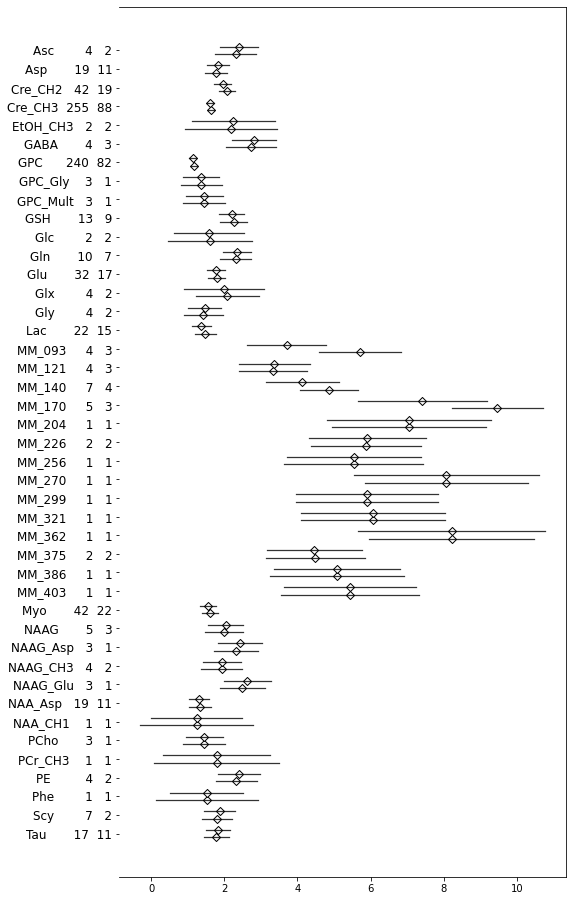

In [121]:
norm_metab  = 'NAA_CH3'

plot        = False
verbose     = False
area        = 65

all_metabs  = list(sorted(set(dfC.Name)))
all_metabs.remove('MM_General')
all_metabs.remove('NAA_CH3')
all_metabs.remove('H2O')
all_metabs.remove('H2O_CSF')

# all_metabs_ = []
# for ii in range(len(all_metabs)):
#     if 'MM_' in all_metabs[ii]:
#         all_metabs_.append(all_metabs[ii])
# for ii in range(len(all_metabs_)):
#     all_metabs.remove(all_metabs_[ii])
        
all_metabs = all_metabs[::-1]
fig, ax     = plt.subplots(figsize=(8,16))
for ii in range(len(all_metabs)):

    names_metab         = available_papers(dfC, norm_metab)
    fields              = breakdown_field(names_metab, dfR, verbose=False)
    df_relative         = norm_comp_values(names_metab, dfR, dfC, norm_metab, all_metabs[ii])
    combination         = comp_df(df_relative, norm_metab, all_metabs[ii])
    df_final            = combination[0]
    Monte_Carlo         = combination[1]

    Indepent_Effects    = Independent_Groups(df_final, Monte_Carlo, norm_metab, all_metabs[ii], plot=plot, verbose=verbose)
    Ind_Fixed_Effect    = Indepent_Effects[0]
    Ind_Random_Effect   = Indepent_Effects[1]
    Ind_Monte_Carlo     = Indepent_Effects[2]
    Ind_N               = Indepent_Effects[3]

    df_combined         = Study_Combined(df_final, clinical=False, verbose=verbose)
    Study_Effects       = Overall_Effects(df_combined, Monte_Carlo, norm_metab, all_metabs[ii], sort_by='Year', plot=plot, verbose=verbose)
    Study_Fixed_Effect  = Study_Effects[0]
    Study_Random_Effect = Study_Effects[1]
    Study_Monte_Carlo   = Study_Effects[2]
    Study_N             = Study_Effects[3]

    ax.plot([Ind_Fixed_Effect[-2], Ind_Fixed_Effect[-1]], [ii-.20, ii-.20], linewidth=1.25, color='k', alpha=.8)
    ax.scatter(Ind_Fixed_Effect[0], ii-.20, color='white', edgecolors='k', marker=(4, 0, 90), s=area)#* (1/Study_Fixed_Effect[1]))
    ax.plot([Study_Fixed_Effect[-2], Study_Fixed_Effect[-1]], [ii+.20, ii+.20], linewidth=1.25, color='k', alpha=.8)
    ax.scatter(Study_Fixed_Effect[0], ii+.20, color='white', edgecolors='k', marker=(4, 0, 90), s=area)#* (1/Study_Fixed_Effect[1]))
    
    print('{:<8} {:<8} {:7.3f}({}{:6.3f}) {:7.3f}({}{:6.3f})  {:3d}  {:3d}'.format(norm_metab, all_metabs[ii], Study_Fixed_Effect[0], u'\u00B1', Study_Fixed_Effect[2] * 1.96, Monte_Carlo[0], u'\u00B1', Monte_Carlo[2], int(Ind_N), int(Study_N)))
    
    all_metabs[ii]      = '{:<8} {:3d} {:3d}'.format(all_metabs[ii][:8], int(Ind_N), int(Study_N))
    # ax.bar(ii, Study_Fixed_Effect[0], width=.40, color='white' , edgecolor='k', linewidth=1.25, hatch=None)
    # # ax.bar(ii-.15, Study_Fixed_Effect[0], width=.30, color='royalblue' , edgecolor='k', linewidth=1.25, hatch=None)
    # # ax.bar(ii+.15, Study_Monte_Carlo[ 0], width=.30, color='darkorange', edgecolor='k', linewidth=1.25, hatch=None)
    # ax.plot([ii, ii], [Study_Fixed_Effect[0], Study_Fixed_Effect[-1]], color='k', linewidth=1.25, )
    # ax.plot([ii, ii], [Study_Fixed_Effect[0], Study_Fixed_Effect[-2]], color='k', linewidth=1.25, )

ylabels = []
ylabels.extend(all_metabs)
ax.set_yticks([y for y in range(0, len(ylabels))]) 
ax.set_yticklabels(ylabels, fontsize=12)
ax.spines['left'].set_visible(False)
# xlabels = []
# xlabels.extend(all_metabs)
# ax.set_xticks([x for x in range(0, len(xlabels))]) 
# ax.set_xticklabels(xlabels, rotation=45, fontsize=12)

# white = mpatches.Patch(facecolor='white', edgecolor='k', hatch=None, label='Fixed Effect')
# hatch = mpatches.Patch(facecolor='white', edgecolor='k', hatch='//' ,label='Monte Carlo ') 
# fig.legend(handles=[white, hatch], loc=1)
plt.show()

In [ ]:
df_test = pd.DataFrame({'Study'     : ['Caroll', 'Grant', 'Peck', 'Donat', 'Stewart', 'Young'],
                        'Hedge\'s G': [.1      , .3     , .35   , .65    , .45      , .15    ],
                        'StdError'  : [.173    , .173   , .224  , .100   , .224     , .141   ],
                        'Variance'  : [.030    , .030   , .050  , .010   , .050     , .020   ],
                       })
df_test['Final_Weight'] = 1/df_test.Variance

Fixed_Effect     = combined_fixed_effect( df_test, Tcol='Hedge\'s G', Wcol='Final_Weight')
Random_Effect    = combined_random_effect(df_test, Tcol='Hedge\'s G', Wcol='Final_Weight')

print('         Fixed Effect   Random Effect')
print('ES   :     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 0], Random_Effect[ 0]))
print('CI-Lw:     {:7.4f}        {:7.4f}'.format(Fixed_Effect[-2], Random_Effect[-2]))
print('CI-Hg:     {:7.4f}        {:7.4f}'.format(Fixed_Effect[-1], Random_Effect[-1]))
print('Var  :     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 1], Random_Effect[ 1]))
print('SE   :     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 2], Random_Effect[ 2]))
print('Z    :     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 3], Random_Effect[ 3]))
print('p1way:     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 4], Random_Effect[ 4]))
print('p2way:     {:7.4f}        {:7.4f}'.format(Fixed_Effect[ 5], Random_Effect[ 5]))


In [8]:
import numpy as np

x    = np.random.normal(300, 2.5, 100)
y    = np.random.normal(200, 3.0, 100)

x_u  = np.mean(x)
y_u  = np.mean(y)

x_std= np.std(x)
y_std= np.std(y)

x_var= x_std ** 2
y_var= y_std ** 2

cov  = np.cov((x,y))[0,1]
cov  = 0

true = x/y

def ratio_taylor_expansion(x_u, y_u, x_var, y_var, cov=0):
    ratio    = (x_u/y_u) - (cov/(y_u**2)) + ((y_var *x_u)/(y_u**3))   
    variance = (x_var/(y_u**2)) - (((2*x_u)/(y_u**3)) * cov) + (((x_u**2) * y_var)/(y_u**4))
    # variance = (x_u**2/y_u**2) * ( ((x_var)/(x_u **2)) - (2 * (cov/(x_u * y_u))) + ((y_var)/(y_u **2))  )
    return ratio, variance

def ratio_of_means(x_n, y_n, x_u, y_u, x_std, y_std):
    ratio    = (x_u/y_u)
    ln_ratio = np.log(ratio)
    se0      = ((1/x_n) * ((x_std/x_u)**2) )
    se1      = ((1/y_n) * ((y_std/y_u)**2) )
    se       = np.sqrt( se0 + se1 )
    CI_low   = np.exp(ln_ratio - 1.96 * se)
    CI_high  = np.exp(ln_ratio + 1.96 * se)
    
    return ratio, se, CI_low, CI_high

ex = ratio_of_means(9, 10, 213, 177, 67, 40)
print(ex[0])
print(ex[1])
print(ex[2])
print(ex[3])
# tay_u, tay_var = ratio_taylor_expansion(x_u, y_u, x_var, y_var, cov=0)
# rom_u, rom_var = ratio_of_means(x_n, y_n, x_u, y_u, x_var, y_var)

# print(ratio_mean(x_u, y_u, x_std, y_std))
# print(np.mean(true))

# print(np.std(true)**2)
# print(ratio_var(x_u, y_u, x_var, y_var, cov))



1.2033898305084745
0.1268892852991767
0.9384172813507314
1.5431803238819226
